In [1]:
%load_ext autoreload
%autoreload 2
from utils import *

# Collecting data

In [2]:
path = "../"
record_names = ["MoscowSpecialistsData/P2.edf", 
                "MoscowSpecialistsData/P3.edf", 
                "MoscowSpecialistsData/P4.edf", 
                "MoscowSpecialistsData/P5.edf", 
                #"MoscowSpecialistsData/P6.edf", 
                "MoscowSpecialistsData/P8.edf", 
                "MoscowSpecialistsData/P23.edf", 
                "MoscowSpecialistsData/P27.edf",
                "MoscowSpecialistsData/P37.edf", 
                "MoscowSpecialistsData/P38.edf", 
                "MoscowSpecialistsData/P44.edf", 
                "MoscowSpecialistsData/P46.edf", 
                "MoscowSpecialistsData/P47.edf", 
                "MoscowSpecialistsData/P48.edf", 
                "MoscowSpecialistsData/P49.edf", 
                #"MoscowSpecialistsData/P50.edf",  #bad segm quality
                "MoscowSpecialistsData/P51.edf"]

records = []
annots = []
times = []
freqs = []
for file_name in record_names:

    sigbufs, new_annot, time, freq = ReadSignal(path + file_name)
    records.append(broad_filter(sigbufs, 199))
    annots.append(new_annot)
    times.append(time)
    freqs.append(freq)
    

In [3]:
normalized_records = [records[i].copy() for i in range(len(records))]
NormalizeAndClip(normalized_records)    

  0%|                                                                                                                                  | 0/15 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.14it/s]


In [ ]:
epi_labels = []

for i in range(len(records)):
    if "Moscow" in record_names[i]:
        epi_labels.append(np.load(path + "MoscowSpecialistsData/Labels/" + 
                                  record_names[i][22:] + "freq" + str(freqs[i])[:3] + ".npy"))

In [ ]:
exp_name = "17RecordsSEED"
splits_dict = ParseSplits(path + "CrossValidationResults/" + exp_name, record_names)

In [6]:
means = []
stds = [] 
for i in range(len(records)):
    inout_seq_char_true, inout_seq_char_pred = CreateSamplesCharacteristics(torch.FloatTensor(records[i].copy()), 
                                                                            torch.LongTensor(epi_labels[i].copy()),
                                                                            torch.LongTensor(epi_labels[i].copy()), 
                                                                            window=2, sr=199)
    means.append(np.mean(inout_seq_char_true, axis=0))
    stds.append(np.std(inout_seq_char_true, axis=0))

In [7]:
epi_data = []
epi_data_normalized = []
for i in range(len(records)):
    time_start = annots[i][0][0]
    time_end = annots[i][-1][0]
    idx_start = (np.array(times[i]) <= time_start).argmin()
    idx_fin = (np.array(times[i]) < time_end).argmin()        

    epi_data.append(torch.FloatTensor(records[i][:, idx_start:idx_fin].copy()))
    epi_data_normalized.append(torch.FloatTensor(normalized_records[i][:, idx_start:idx_fin].copy()))

    

    current_labels = epi_labels[i][idx_start:idx_fin]
    new_trainl = torch.zeros(2, len(current_labels))
    new_trainl = (torch.arange(2) == torch.LongTensor(current_labels)[:,None]).T
    new_trainl = new_trainl.float()
    epi_labels[i] = new_trainl

# SEED

In [ ]:
model = SEED(OVERLAP, input_dim=20)

In [9]:
seed_segm_model_predictions = []
model_name = "SEED"
for i in range(len(records)):
    split_name = splits_dict[record_names[i]]
    model.load_state_dict(torch.load(path + "CrossValidationResults/" + exp_name + "/" + split_name +"/" + model_name, 
                                     map_location=torch.device('cpu')))  
    all_preds = CollectingPreds(model, [epi_data_normalized[i]], model_name=model_name)
    PostProcessing(all_preds[0], 30)
    seed_segm_model_predictions += all_preds

  0%|                                                                                                                                  | 0/29 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 15.15it/s]


In [10]:
seed_test_samples_char_true, seed_test_samples_char_pred, seed_epi_dif = CharsFromPredictions(epi_data, epi_labels, 
                                                                                              seed_segm_model_predictions, overlap=520)

/home/gromov_n/nikolay/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gromov_n/nikolay/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [11]:
seed_chars_answers, seed_chars_preds, seed_chars_difs = DownloadChatsPredictions("CharsSEED17Records",
                                                                                  record_names, records, splits_dict, path)

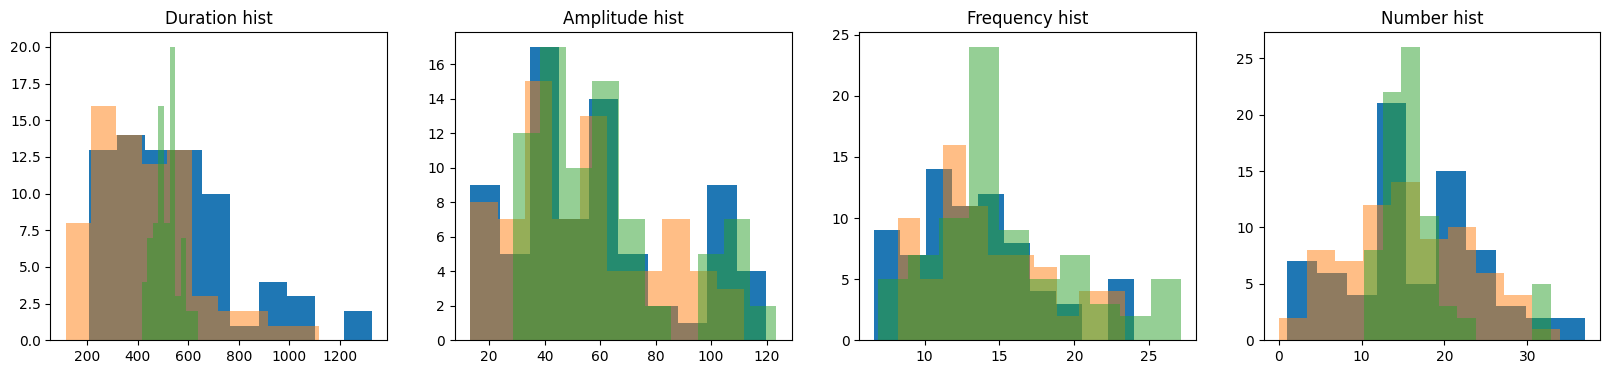

In [12]:
f, axes = plt.subplots(1, 4, figsize=(20, 4))
titles = ["Duration hist", "Amplitude hist", "Frequency hist", "Number hist"]
for i in range(4):
    axes[i].hist(seed_test_samples_char_true[:, i])
    axes[i].hist(seed_test_samples_char_pred[:, i], alpha=0.5)
    axes[i].hist(seed_chars_preds[i], alpha=0.5)


    axes[i].set_title(titles[i])

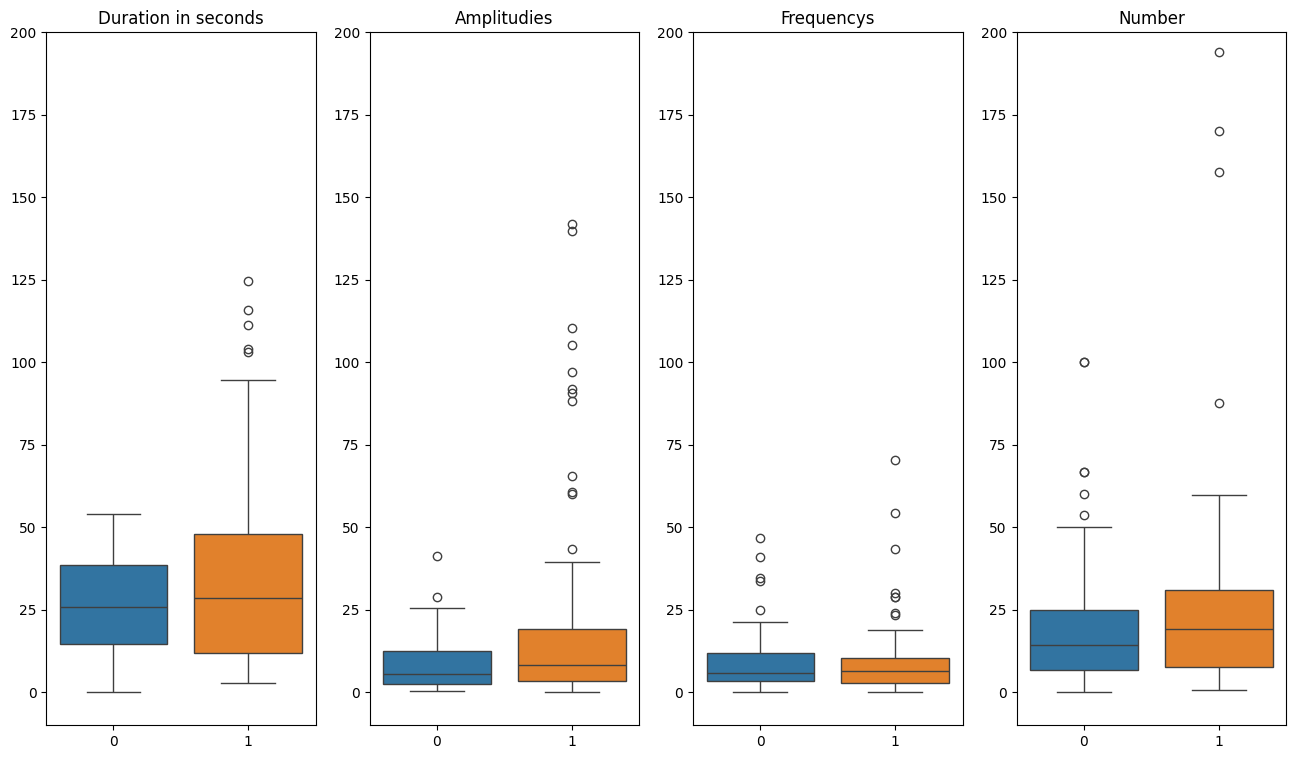

In [13]:
titles = ["Duration in seconds", "Amplitudies", "Frequencys", "Number"]
f, axes = plt.subplots(1, 4, figsize=(16, 9))
for i in range(4):
    sns.boxplot([seed_epi_dif.T[i] / seed_test_samples_char_true.T[i] * 100, seed_chars_difs[i] / seed_chars_answers[i] * 100], ax=axes[i])
    axes[i].set_title(titles[i])

    axes[i].set_ylim(bottom=-10, top=200)


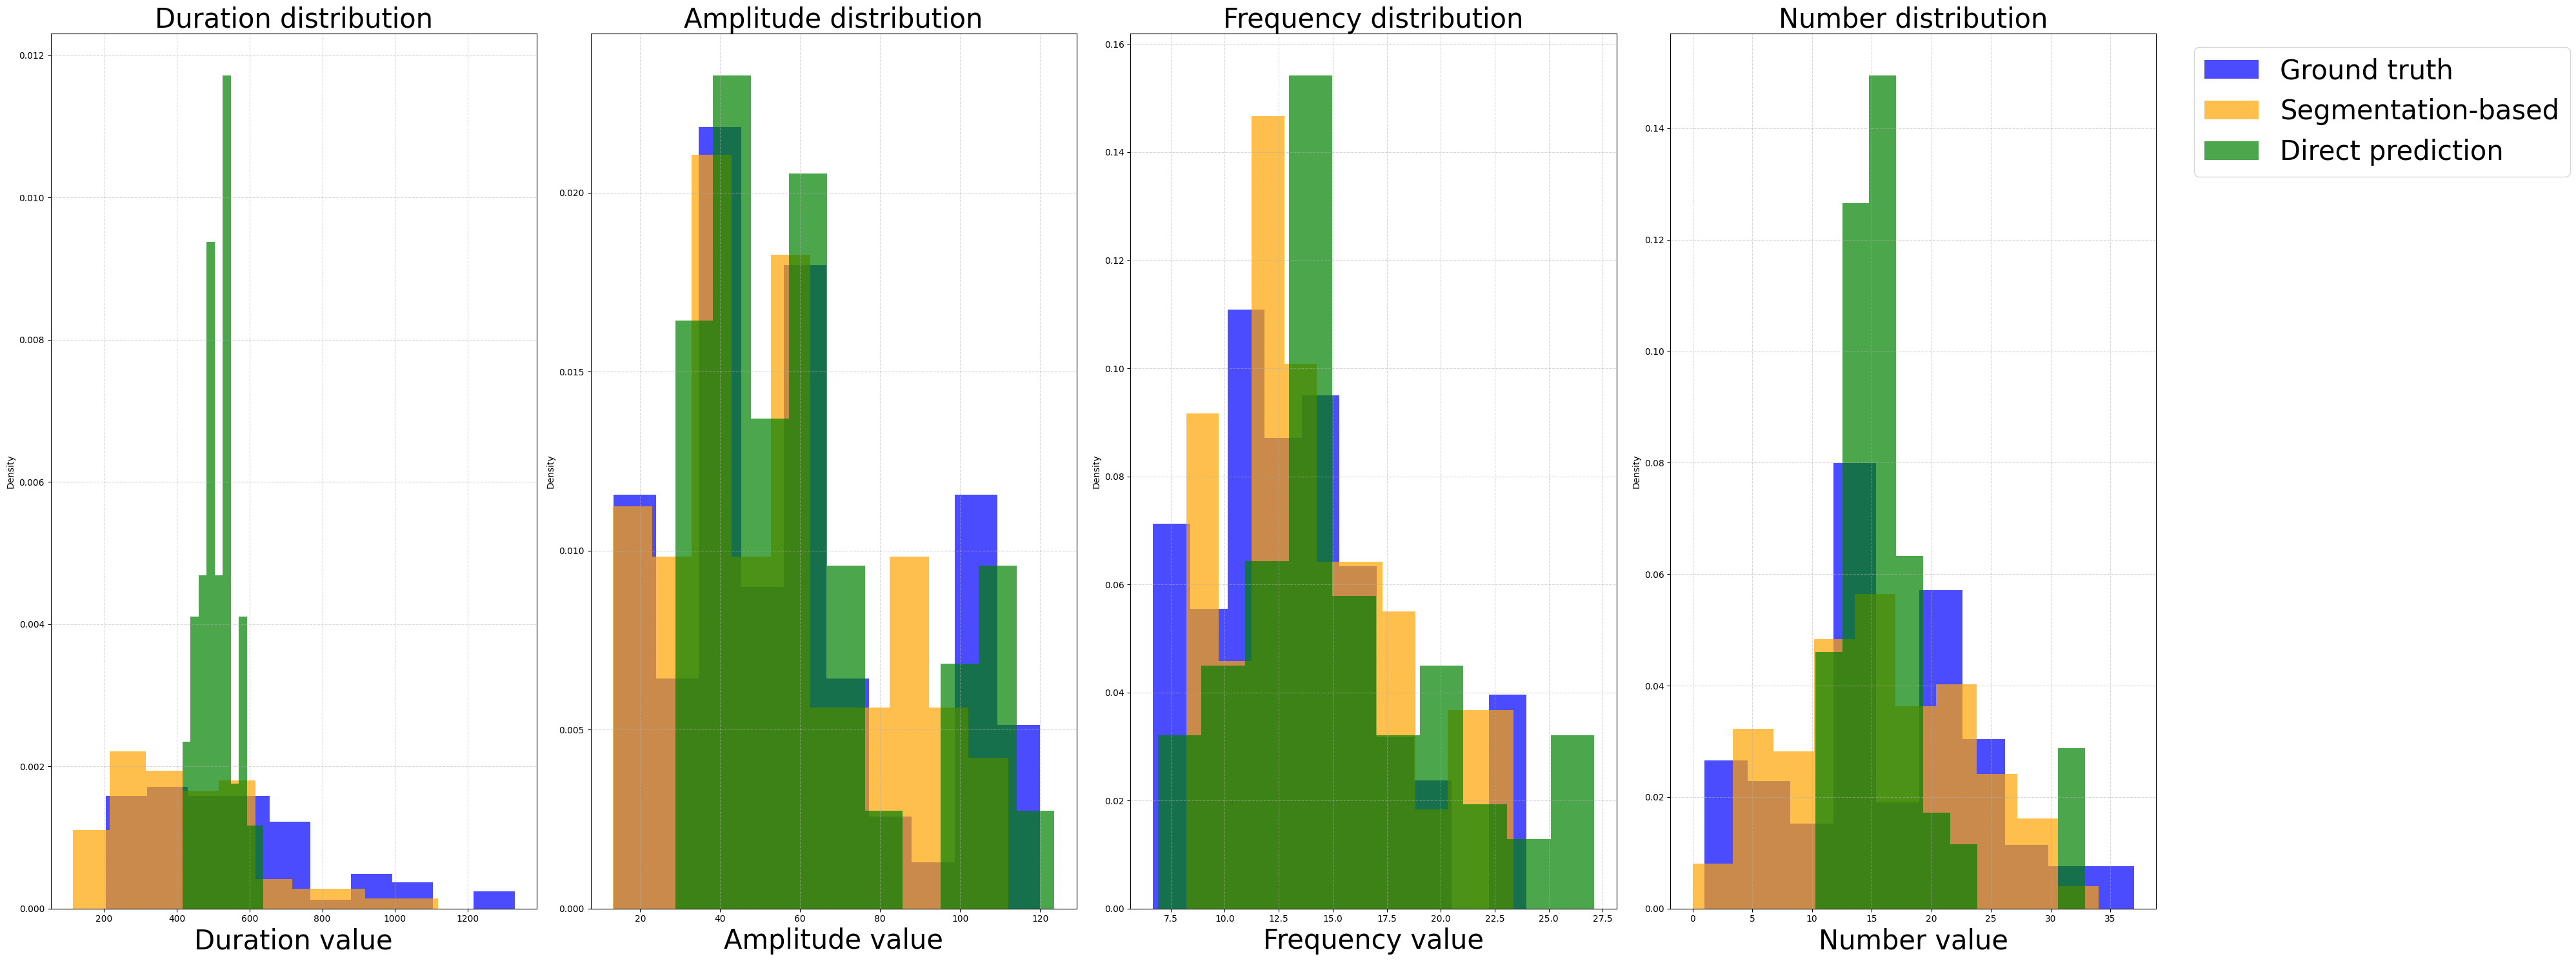

In [31]:
f, axes = plt.subplots(1, 4, figsize=(40, 15))
titles = ["Duration", "Amplitude", "Frequency", "Number"]
colors = ['blue', 'orange', 'green']

for i in range(4):
    axes[i].hist(seed_test_samples_char_true[:, i], color=colors[0], alpha=0.7, 
                 label='Ground truth', density=True)
    axes[i].hist(seed_test_samples_char_pred[:, i], color=colors[1], alpha=0.7, 
                 label='Segmentation-based', density=True)
    axes[i].hist(seed_chars_preds[i], color=colors[2], alpha=0.7, 
                 label='Direct prediction', density=True)
    
    axes[i].set_title(f"{titles[i]} distribution", fontsize=30)
    axes[i].set_xlabel(titles[i] + ' value', fontsize=30)
    axes[i].set_ylabel('Density')
    axes[i].grid(True, linestyle='--', alpha=0.5)

axes[-1].legend(fontsize=30, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

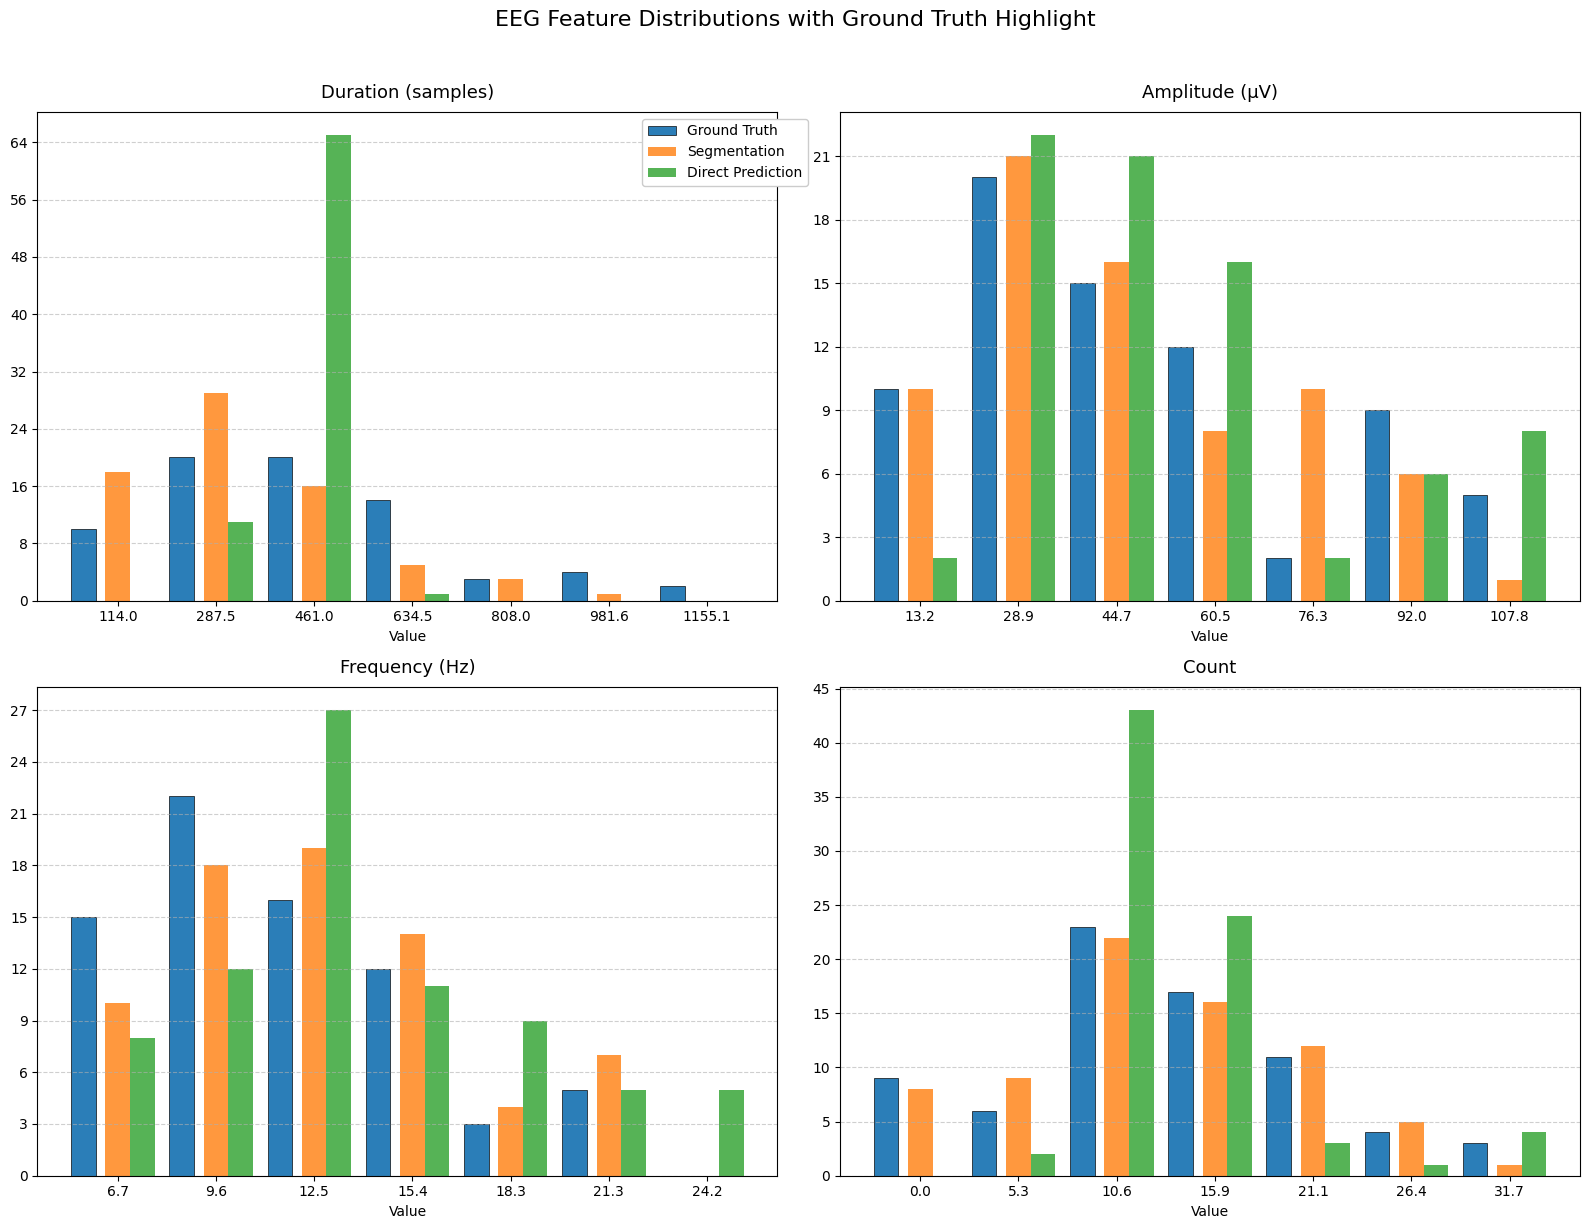

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Настройки
metrics = ['Duration (samples)', 'Amplitude (μV)', 'Frequency (Hz)', 'Count']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # blue, orange, green
bar_width = 0.25
gt_offset = 0.1  # Дополнительное смещение для GT

# Создаем 4 подграфика
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

for i, ax in enumerate(axes.flat):
    # Подготовка данных
    true_vals = np.ma.filled(seed_test_samples_char_true[:, i], np.nan)
    seg_vals = np.ma.filled(seed_test_samples_char_pred[:, i], np.nan)
    dir_vals = np.ma.filled(seed_chars_preds[i], np.nan)
    
    # Общие bins
    combined = np.concatenate([true_vals[~np.isnan(true_vals)], 
                              seg_vals[~np.isnan(seg_vals)],
                              dir_vals[~np.isnan(dir_vals)]])
    bins = np.linspace(np.min(combined), np.max(combined), 8)
    
    # Гистограммы
    hist_true, _ = np.histogram(true_vals, bins=bins)
    hist_seg, _ = np.histogram(seg_vals, bins=bins)
    hist_dir, _ = np.histogram(dir_vals, bins=bins)
    
    # Позиции с дополнительным смещением GT
    x = np.arange(len(bins)-1)
    ax.bar(x - bar_width - gt_offset, hist_true, width=bar_width,  # Смещаем GT левее
           color=colors[0], alpha=0.95, label='Ground Truth',
           edgecolor='black', linewidth=0.5)
    ax.bar(x, hist_seg, width=bar_width,
           color=colors[1], alpha=0.8, label='Segmentation')
    ax.bar(x + bar_width, hist_dir, width=bar_width,
           color=colors[2], alpha=0.8, label='Direct Prediction')
    
    # Оформление
    ax.set_title(metrics[i], fontsize=13, pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels([f"{bins[j]:.1f}" for j in range(len(bins)-1)], fontsize=10)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.set_xlabel('Value', fontsize=10)
    
    if i == 0:
        ax.legend(fontsize=10, framealpha=1, bbox_to_anchor=(1.05, 1))

plt.suptitle('EEG Feature Distributions with Ground Truth Highlight', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

/tmp/ipykernel_2466578/2997552946.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(labels, rotation=45, fontsize=30)
/tmp/ipykernel_2466578/2997552946.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(labels, rotation=45, fontsize=30)
/tmp/ipykernel_2466578/2997552946.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(labels, rotation=45, fontsize=30)
/tmp/ipykernel_2466578/2997552946.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(labels, rotation=45, fontsize=30)


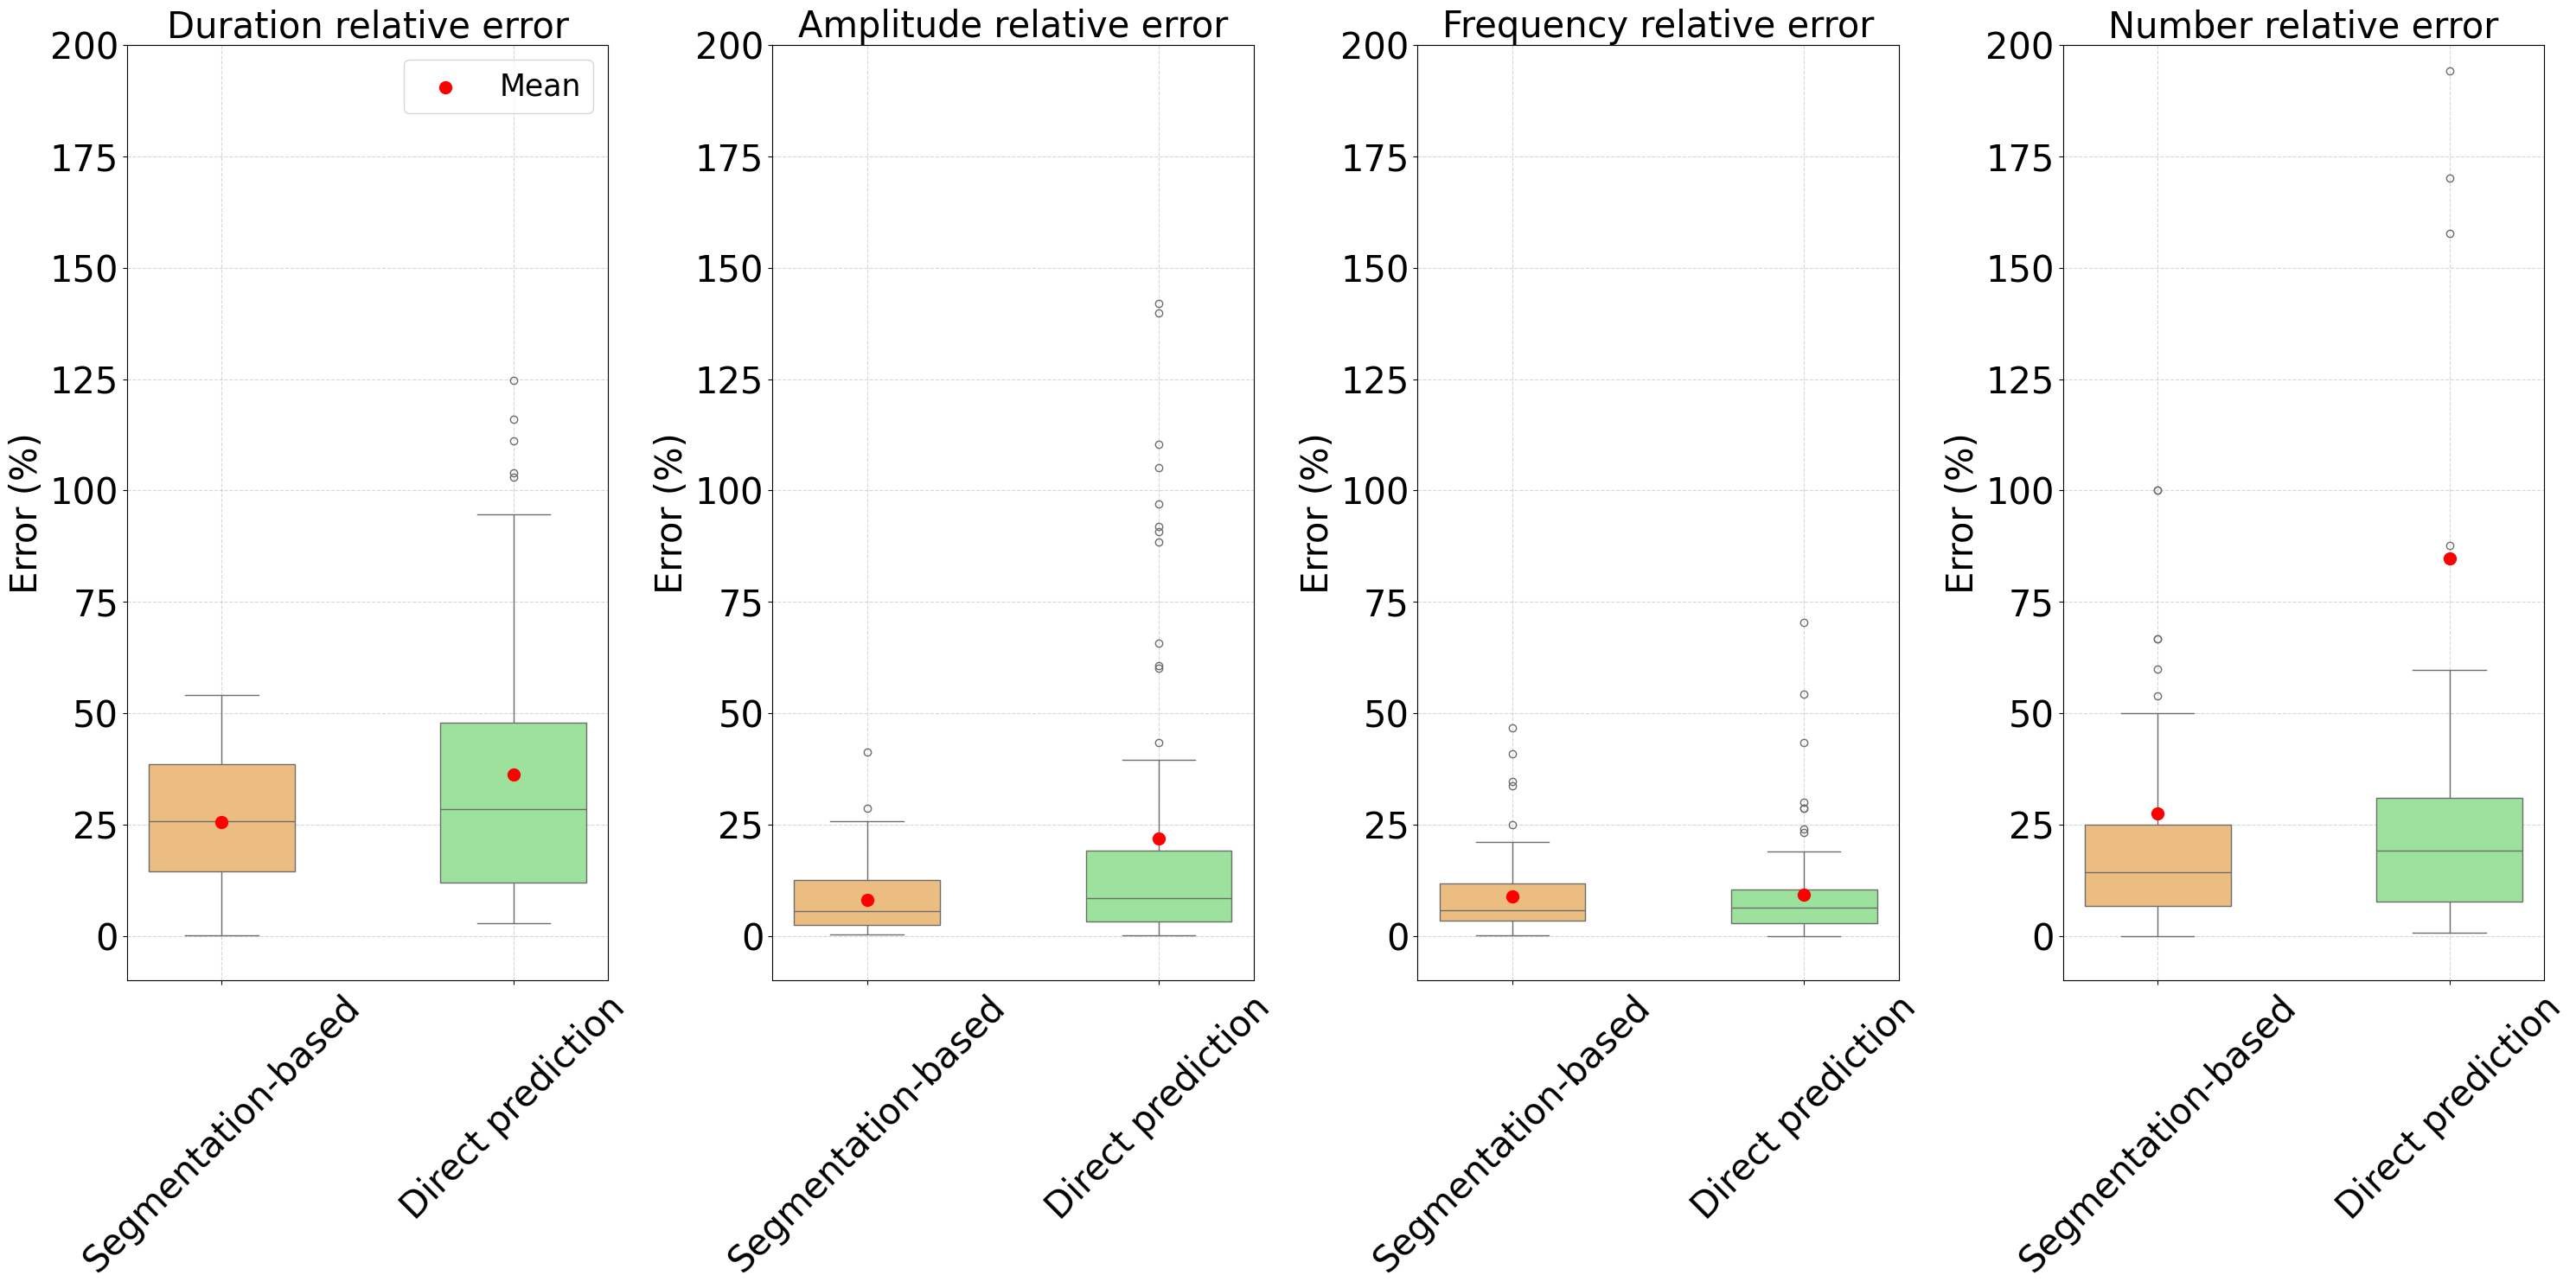

In [58]:
f, axes = plt.subplots(1, 4, figsize=(30, 15))
titles = ["Duration", "Amplitude", "Frequency", "Number"]
labels = ['Segmentation-based', 'Direct prediction']

for i in range(4):
    # Обрабатываем данные для segmentation-based
    seg_data = seed_epi_dif.T[i] / seed_test_samples_char_true.T[i] * 100
    seg_data = np.ma.filled(seg_data, np.nan)  # Заменяем masked значения на NaN
    
    # Обрабатываем данные для direct prediction
    direct_data = seed_chars_difs[i] / seed_chars_answers[i] * 100
    direct_data = np.ma.filled(direct_data, np.nan)  # Заменяем masked значения на NaN
    
    # Удаляем NaN значения перед построением
    clean_seg_data = seg_data[~np.isnan(seg_data)]
    clean_direct_data = direct_data[~np.isnan(direct_data)]
    
    data = [clean_seg_data, clean_direct_data]
    
    # Создаем boxplot только с валидными данными
    sns.boxplot(data=data, ax=axes[i], width=0.5, 
                palette=['#fdbf6f', 'lightgreen'])
    
    # Добавляем средние значения (только если есть данные)
    for j, d in enumerate(data):
        if len(d) > 0:  # Проверяем, что есть данные для отображения
            axes[i].scatter(j, np.mean(d), color='red', zorder=5, 
                           s=100, label='Mean' if j==0 else "")
    
    axes[i].set_title(f"{titles[i]} relative error", fontsize=30)
    axes[i].set_xticklabels(labels, rotation=45, fontsize=30)
    axes[i].set_ylabel('Error (%)', fontsize=30)
    axes[i].tick_params(axis='y', labelsize=30)
    axes[i].set_ylim(bottom=-10, top=200)
    axes[i].grid(True, linestyle='--', alpha=0.5)
    
    if i == 0:
        axes[i].legend(fontsize=25)

plt.tight_layout()

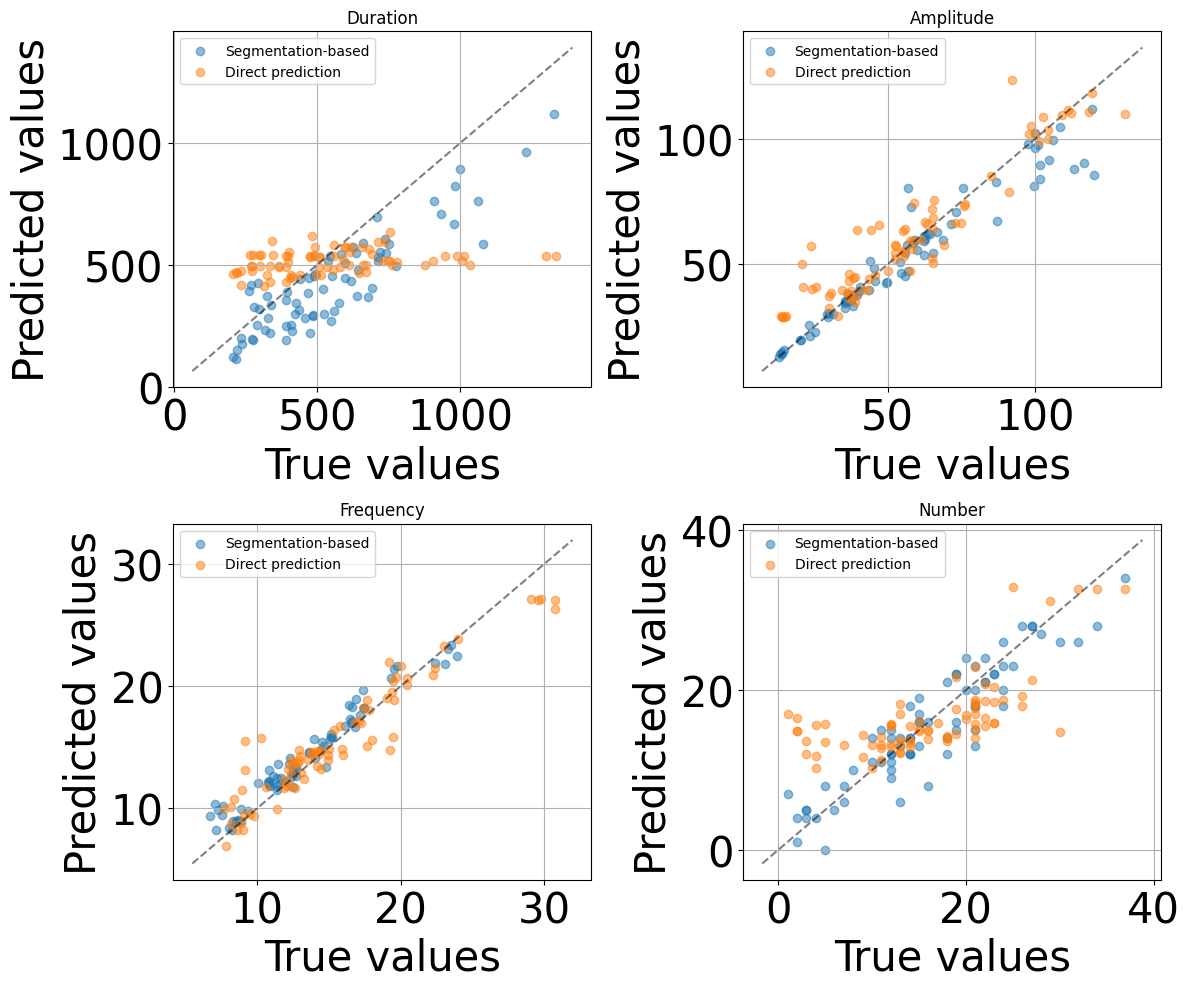

In [50]:
f, axes = plt.subplots(2, 2, figsize=(12, 10))
metrics = ['Duration', 'Amplitude', 'Frequency', 'Number']

for i, ax in enumerate(axes.flat):
    # Для подхода с сегментацией
    ax.scatter(seed_test_samples_char_true[:, i], seed_test_samples_char_pred[:, i], 
               alpha=0.5, label='Segmentation-based')
    # Для прямого предсказания
    ax.scatter(seed_chars_answers[i], seed_chars_preds[i], 
               alpha=0.5, label='Direct prediction')
    
    # Линия идеального предсказания
    lims = [
        min(ax.get_xlim()[0], ax.get_ylim()[0]),
        max(ax.get_xlim()[1], ax.get_ylim()[1])
    ]
    ax.plot(lims, lims, 'k--', alpha=0.5)
    
    ax.set_title(metrics[i])
    ax.set_xlabel('True values', fontsize=30)
    ax.set_ylabel('Predicted values', fontsize=30)
    ax.tick_params(labelsize=30)
    ax.legend()
    ax.grid(True)

plt.tight_layout()

Если нет синих точек, то такие веретена не размечались сетью

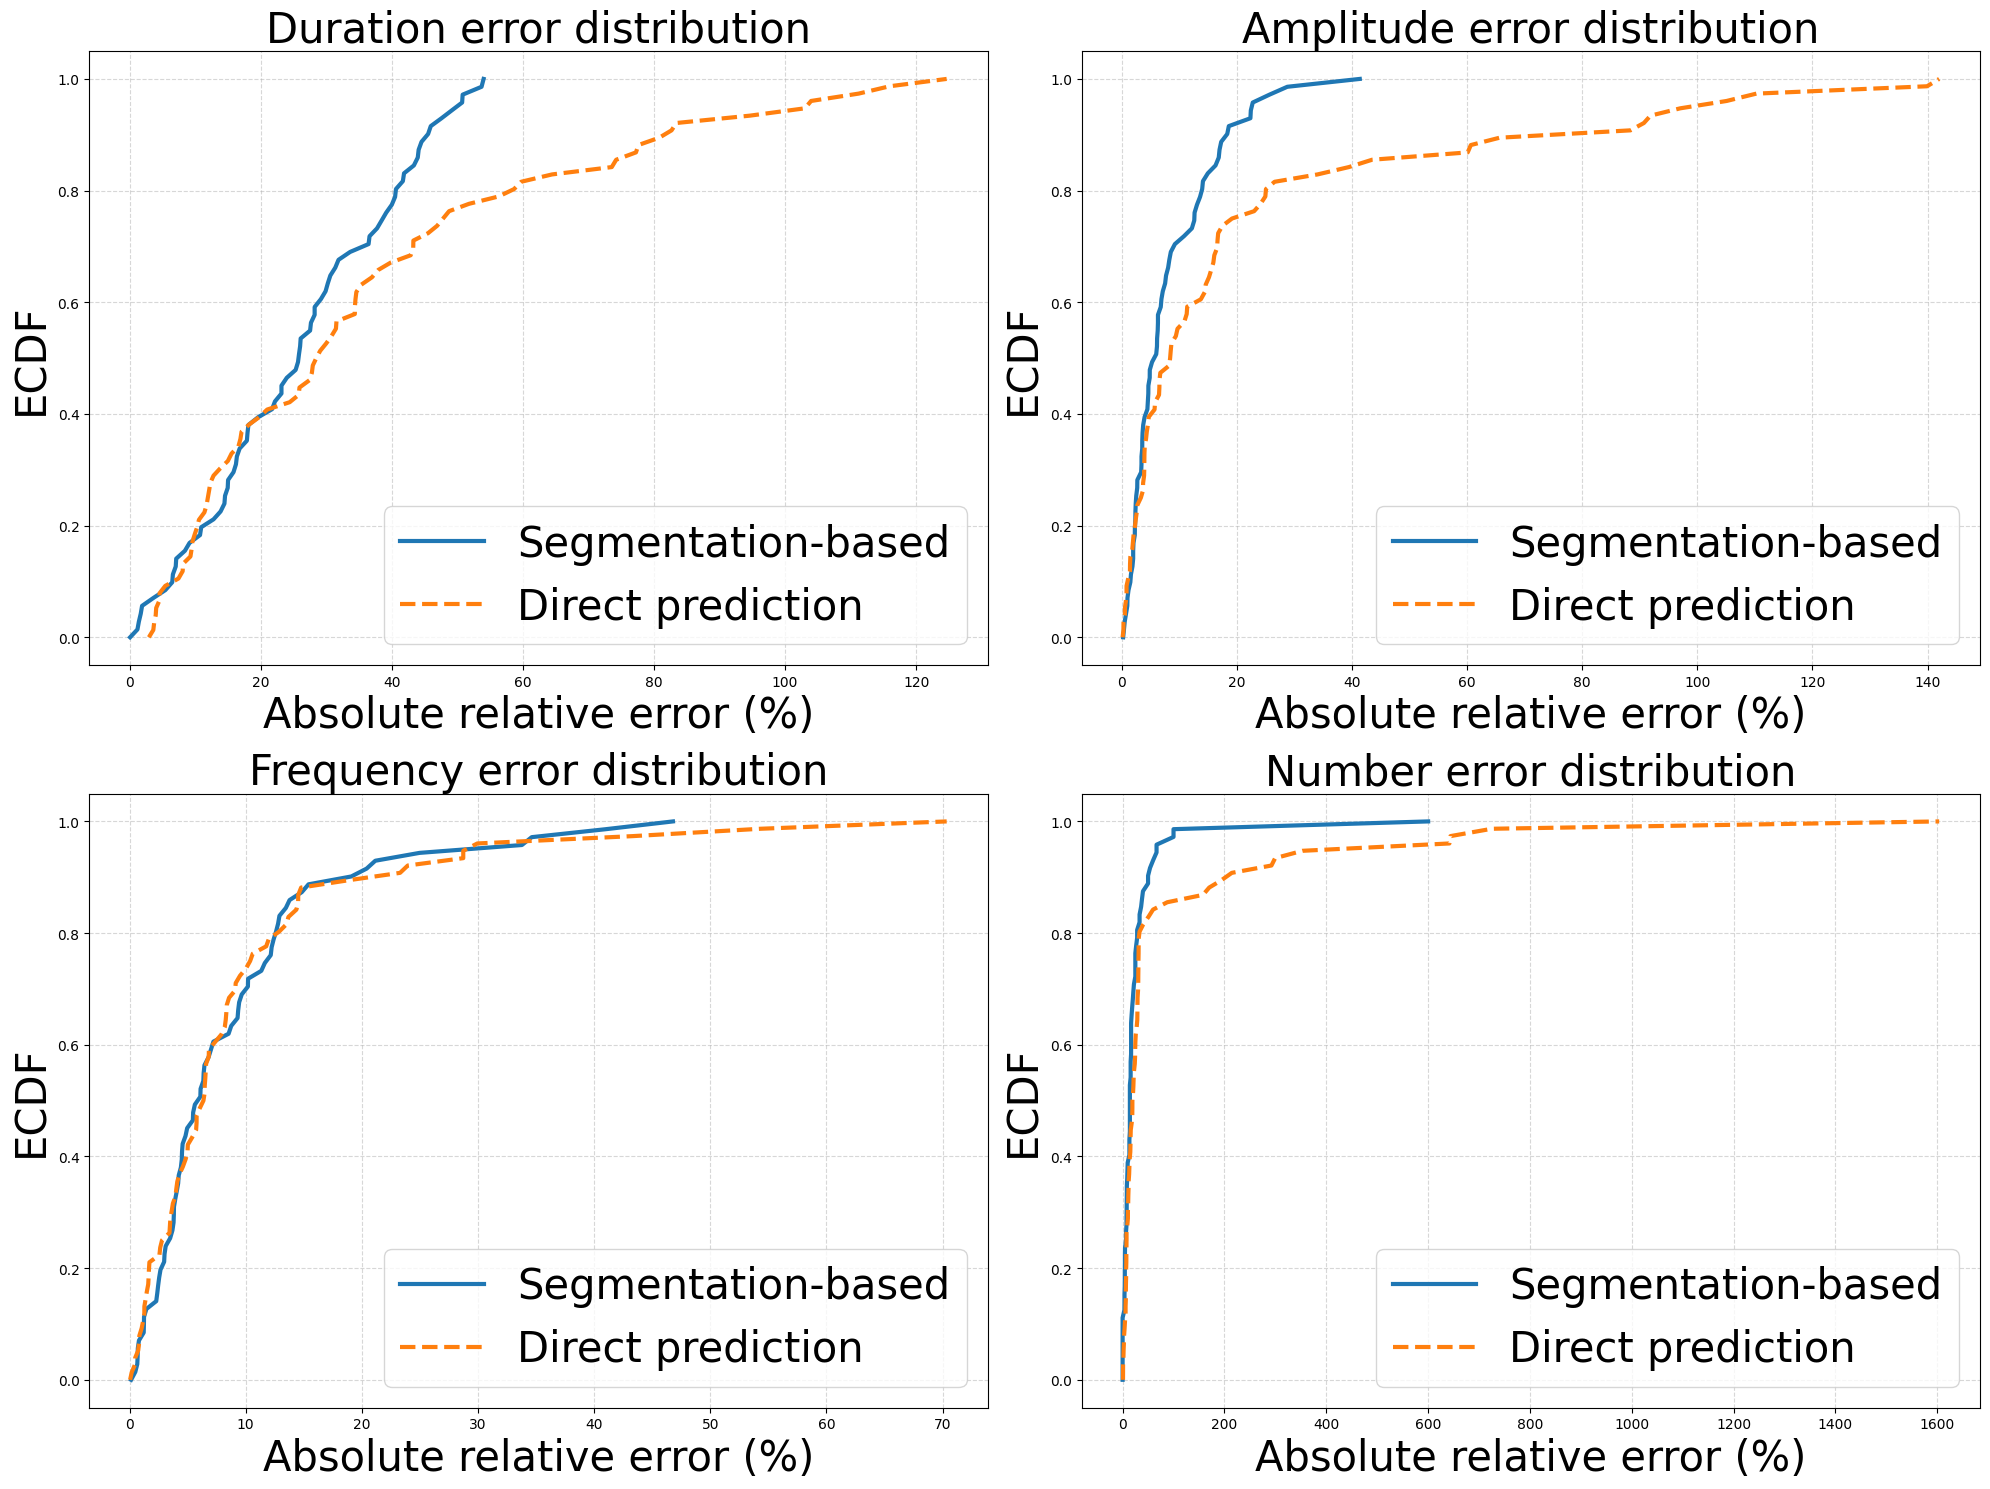

In [43]:
plt.figure(figsize=(20, 15))
metrics = ['Duration', 'Amplitude', 'Frequency', 'Number']

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    
    # Вычисляем относительные ошибки для обоих методов
    seg_errors = np.abs(seed_epi_dif.T[i-1] / seed_test_samples_char_true.T[i-1] * 100)
    direct_errors = np.abs(seed_chars_difs[i-1] / seed_chars_answers[i-1] * 100)
    
    # Очищаем от masked и nan значений
    seg_errors = np.ma.filled(seg_errors, np.nan)
    direct_errors = np.ma.filled(direct_errors, np.nan)
    seg_errors = seg_errors[~np.isnan(seg_errors)]
    direct_errors = direct_errors[~np.isnan(direct_errors)]
    
    # Сортируем для ECDF
    seg_sorted = np.sort(seg_errors)
    direct_sorted = np.sort(direct_errors)
    
    # Строим ECDF
    plt.plot(seg_sorted, np.linspace(0, 1, len(seg_sorted)), 
             linewidth=3, label='Segmentation-based')
    plt.plot(direct_sorted, np.linspace(0, 1, len(direct_sorted)), 
             '--', linewidth=3, label='Direct prediction')
    
    plt.xlabel('Absolute relative error (%)', fontsize=30)
    plt.ylabel('ECDF', fontsize=30)
    plt.title(f'{metric} error distribution', fontsize=30)
    plt.legend(fontsize=30)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Добавляем аннотацию с количеством образцов
    # plt.annotate(f'N (seg)={len(seg_sorted)}\nN (dir)={len(direct_sorted)}',
    #              xy=(0.7, 0.1), xycoords='axes fraction', fontsize=12)

plt.tight_layout()
plt.show()

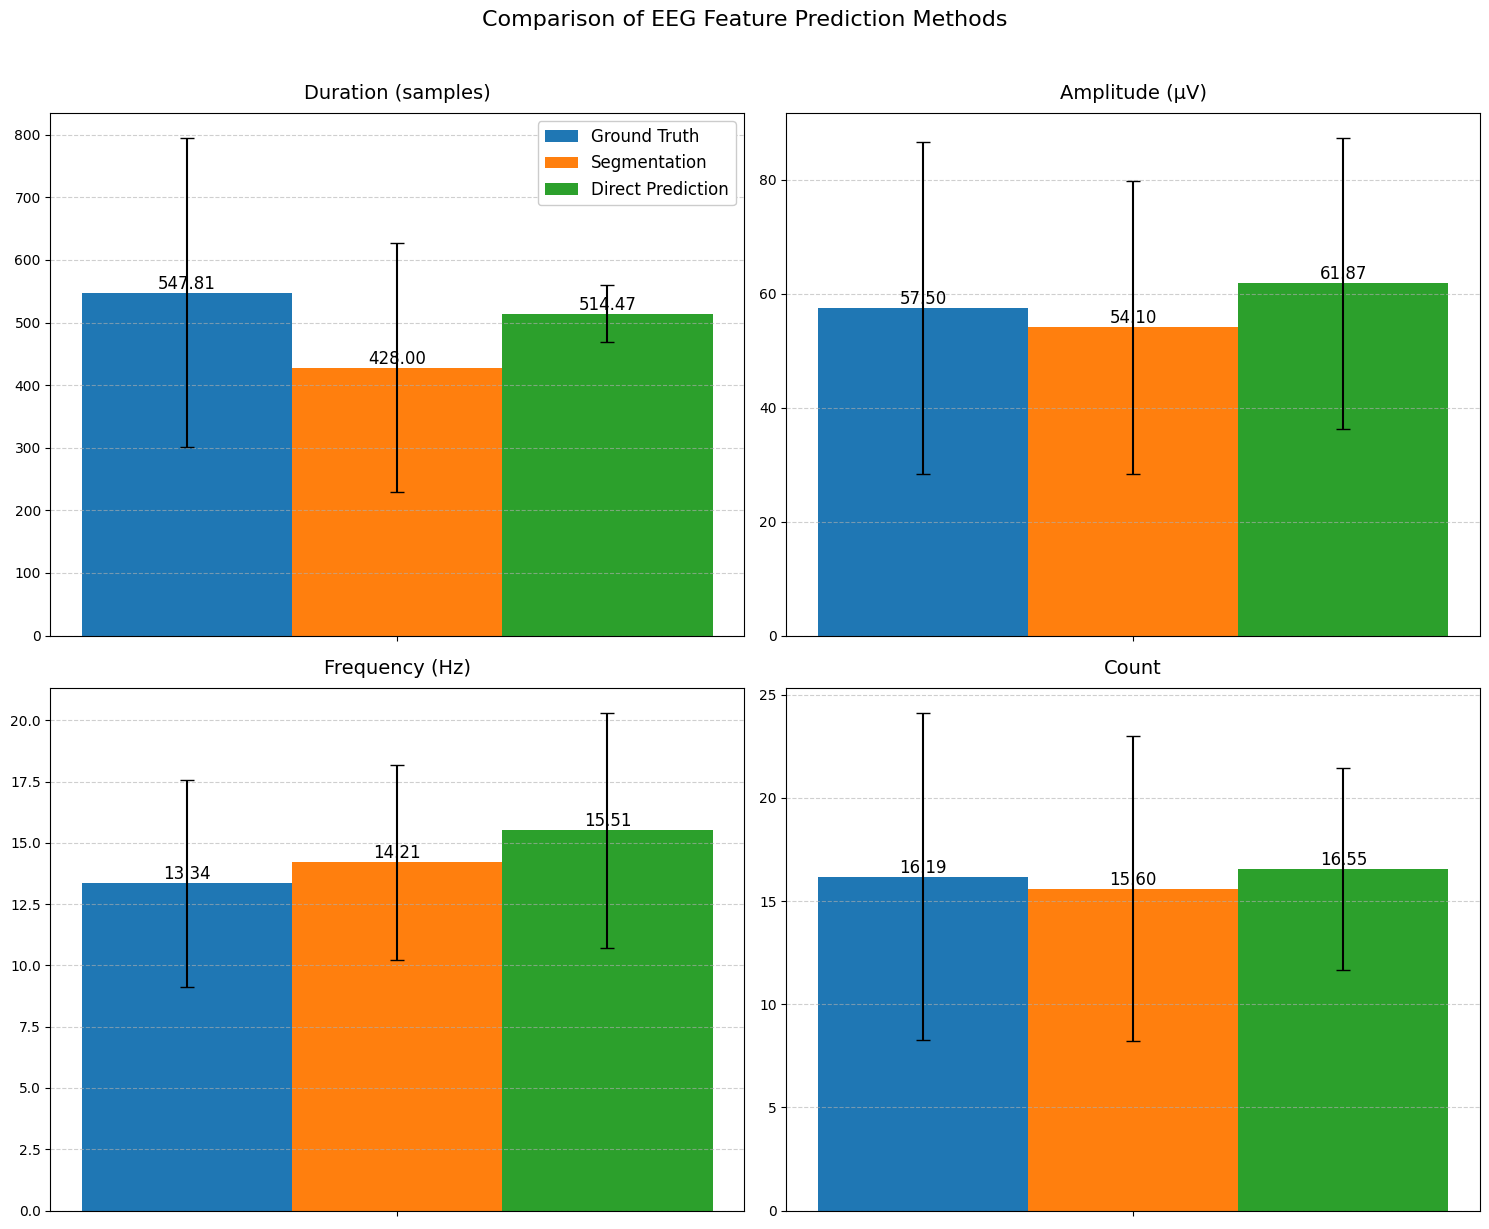

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Данные (примерные, замените на ваши)
metrics = ['Duration (samples)', 'Amplitude (μV)', 'Frequency (Hz)', 'Count']
true_means = [np.mean(seed_test_samples_char_true[:, i]) for i in range(4)]
seg_means = [np.mean(seed_test_samples_char_pred[:, i][~np.isnan(seed_test_samples_char_pred[:, i])]) for i in range(4)]
direct_means = [np.mean(seed_chars_preds[i]) for i in range(4)]

# Ошибки (стандартное отклонение)
true_stds = [np.std(seed_test_samples_char_true[:, i]) for i in range(4)]
seg_stds = [np.std(seed_test_samples_char_pred[:, i][~np.isnan(seed_test_samples_char_pred[:, i])]) for i in range(4)]
direct_stds = [np.std(seed_chars_preds[i]) for i in range(4)]

# Создаем 4 подграфика
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.4)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # blue, orange, green

for i, ax in enumerate(axes.flat):
    # Позиции столбцов
    x = np.arange(1)
    width = 0.25
    
    # Столбцы
    rects1 = ax.bar(x - width, true_means[i], width, 
                    label='Ground Truth', color=colors[0],  # green
                    yerr=true_stds[i], capsize=5)
    rects2 = ax.bar(x, seg_means[i], width, 
                    label='Segmentation', color=colors[1],  # blue
                    yerr=seg_stds[i], capsize=5)
    rects3 = ax.bar(x + width, direct_means[i], width, 
                    label='Direct Prediction', color=colors[2],  # orange
                    yerr=direct_stds[i], capsize=5)
    
    # Настройки графика
    ax.set_title(metrics[i], fontsize=14, pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels([''])
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    
    # Добавляем значения над столбцами
    for rect in [rects1, rects2, rects3]:
        height = rect[0].get_height()
        ax.text(rect[0].get_x() + rect[0].get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=12)
    
    # Добавляем легенду только на первом графике
    if i == 0:
        ax.legend(fontsize=12, framealpha=1)

# Общий заголовок
plt.suptitle('Comparison of EEG Feature Prediction Methods', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Convolutions

In [14]:
unet_segm_model_predictions = []
model_name = "Unet1d"
exp_name = "17RecordsUnet1d"
model = UNET_1D(20,128,7,3)
for i in range(len(records)):
    split_name = splits_dict[record_names[i]]
    model.load_state_dict(torch.load(path + "CrossValidationResults/" + exp_name + "/" + split_name +"/" + model_name, 
                                     map_location=torch.device('cpu')))  
    all_preds = CollectingPreds(model, [epi_data_normalized[i]], model_name=model_name)
    PostProcessing(all_preds[0], 30)
    unet_segm_model_predictions += all_preds

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.18it/s]


In [15]:
unet_test_samples_char_true, unet_test_samples_char_pred, unet_epi_dif = CharsFromPredictions(epi_data, epi_labels, unet_segm_model_predictions, overlap=0)

In [16]:
unet_chars_answers, unet_chars_preds, unet_chars_difs = DownloadChatsPredictions("SlumberNetEpiNumBlocks8Records17",
                                                                                  record_names, records, splits_dict, path)

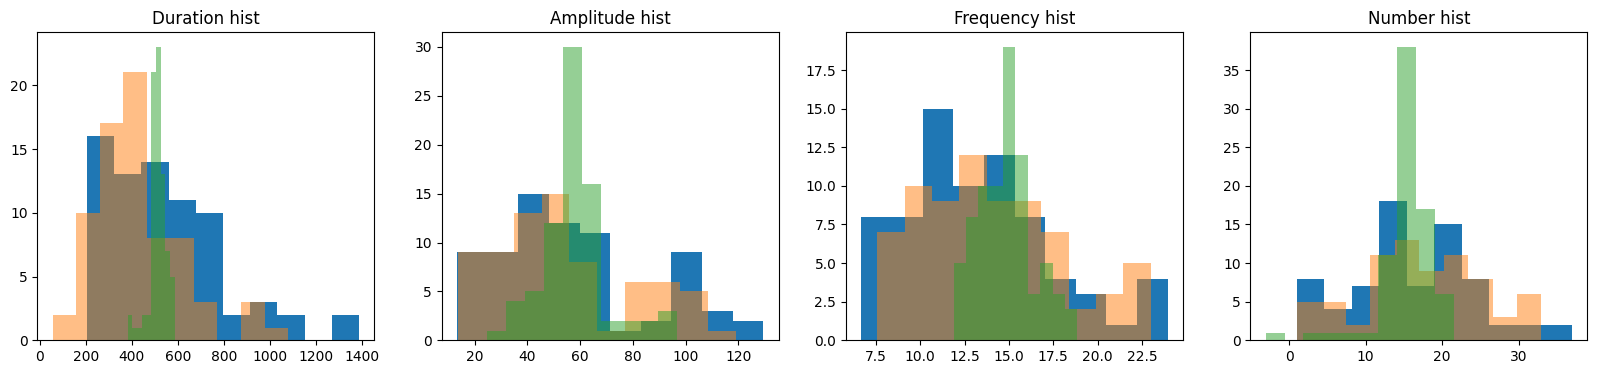

In [17]:
f, axes = plt.subplots(1, 4, figsize=(20, 4))
titles = ["Duration hist", "Amplitude hist", "Frequency hist", "Number hist"]
for i in range(4):
    axes[i].hist(unet_test_samples_char_true[:, i])
    axes[i].hist(unet_test_samples_char_pred[:, i], alpha=0.5)
    axes[i].hist(unet_chars_preds[i], alpha=0.5)


    axes[i].set_title(titles[i])

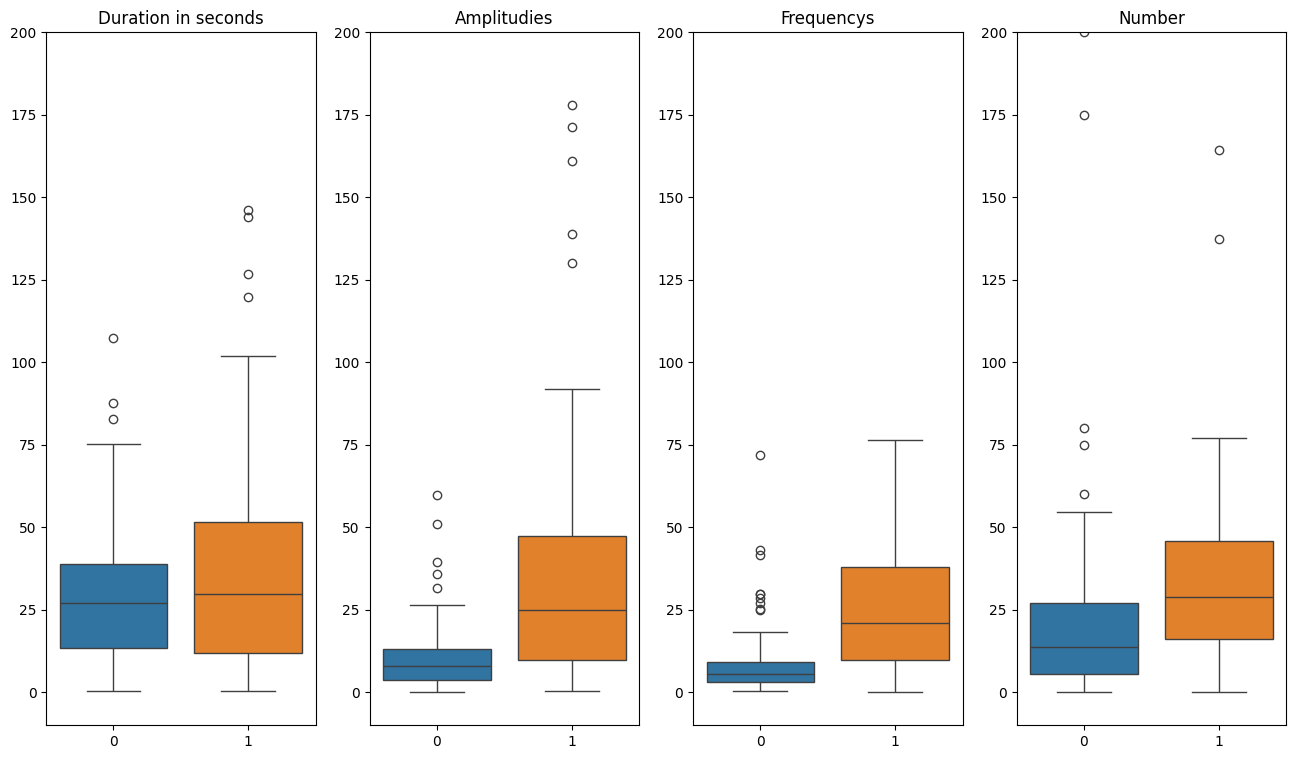

In [18]:
titles = ["Duration in seconds", "Amplitudies", "Frequencys", "Number"]
f, axes = plt.subplots(1, 4, figsize=(16, 9))
for i in range(4):
    sns.boxplot([unet_epi_dif.T[i] / unet_test_samples_char_true.T[i] * 100, unet_chars_difs[i] / unet_chars_answers[i] * 100], ax=axes[i])
    axes[i].set_title(titles[i])

    axes[i].set_ylim(bottom=-10, top=200)


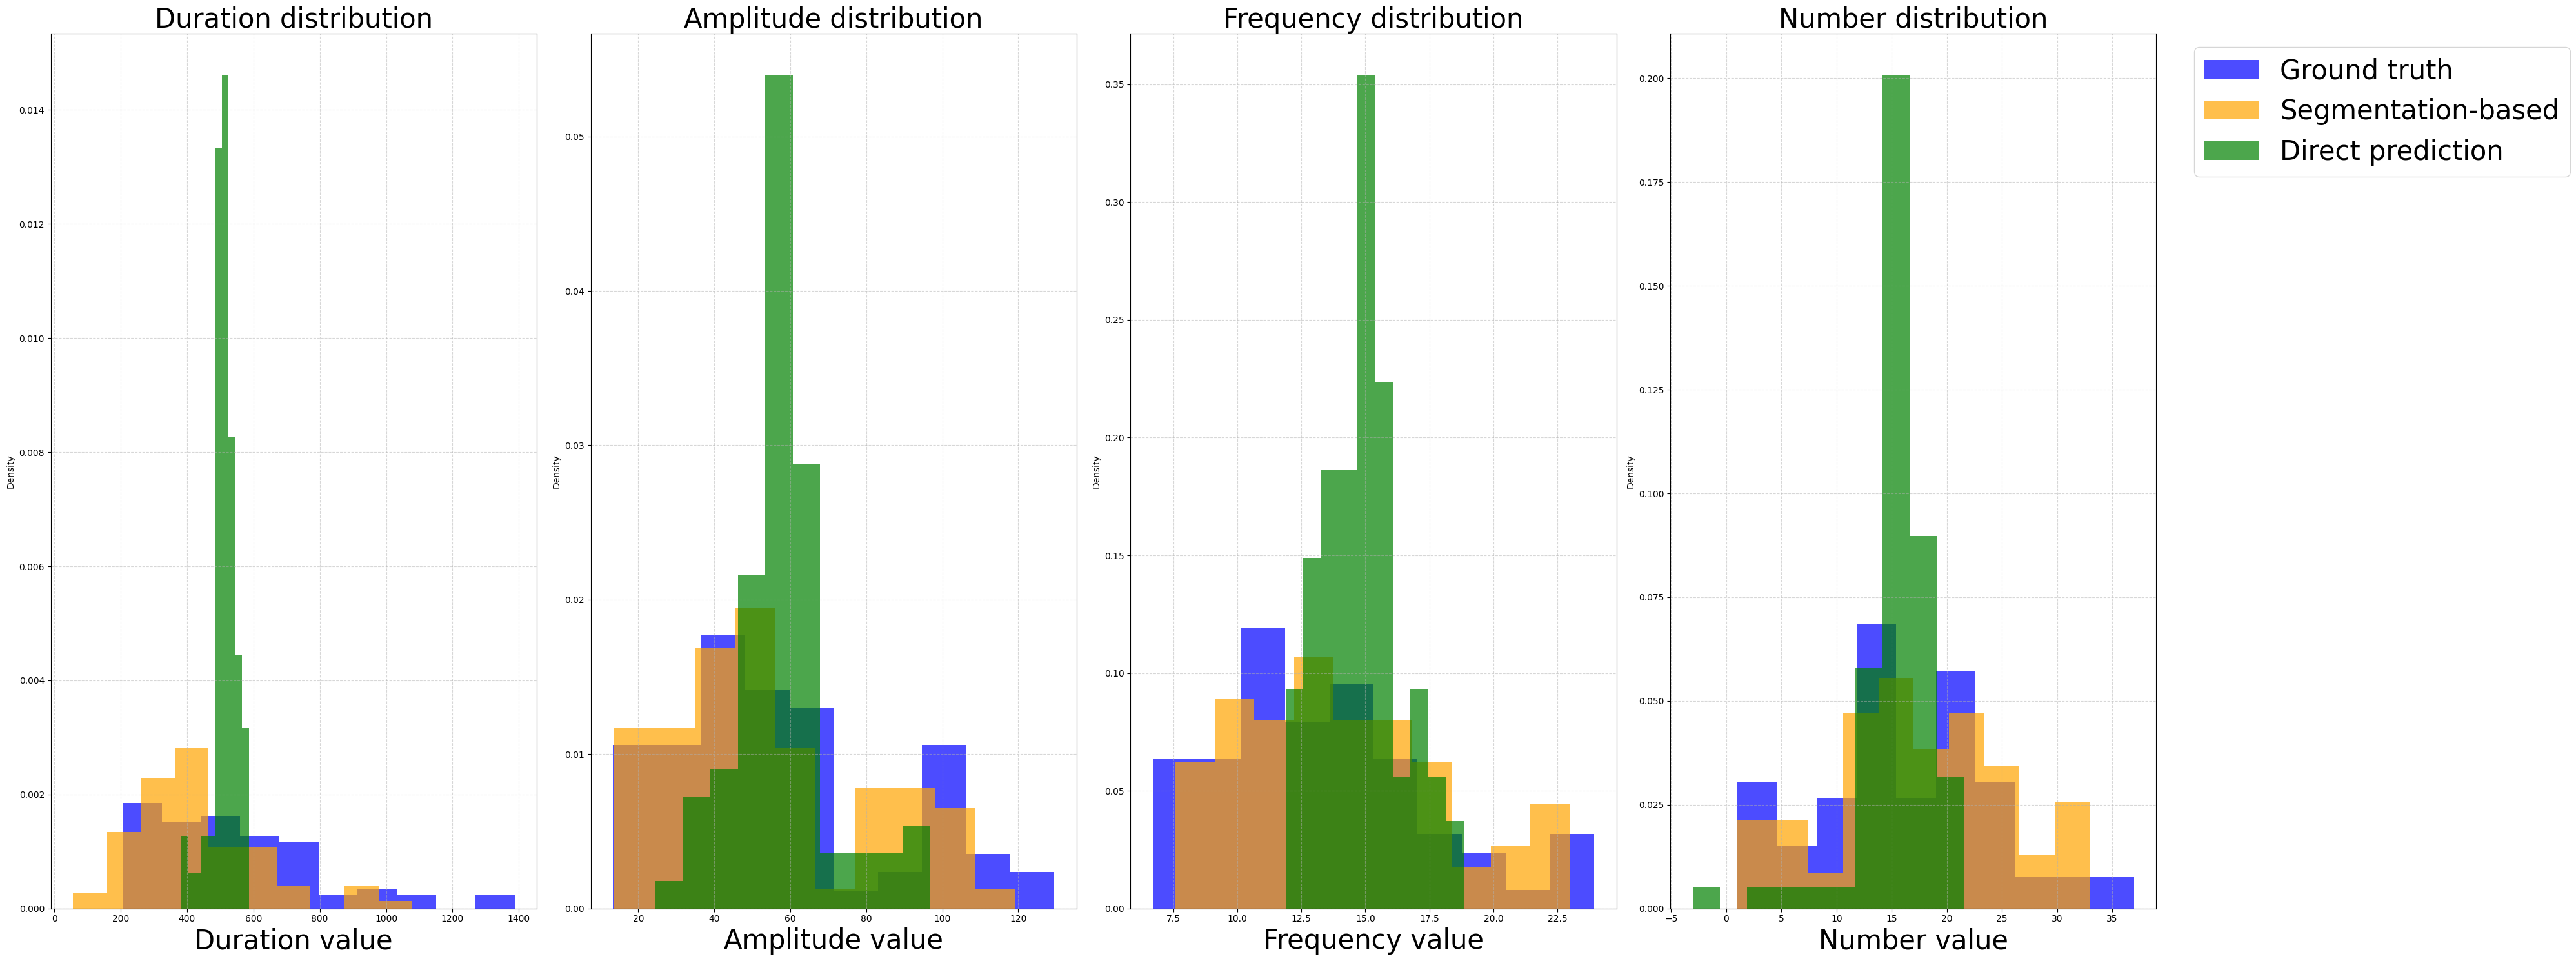

In [29]:
f, axes = plt.subplots(1, 4, figsize=(40, 15))
titles = ["Duration", "Amplitude", "Frequency", "Number"]
colors = ['blue', 'orange', 'green']

for i in range(4):
    axes[i].hist(unet_test_samples_char_true[:, i], color=colors[0], alpha=0.7, 
                 label='Ground truth', density=True)
    axes[i].hist(unet_test_samples_char_pred[:, i], color=colors[1], alpha=0.7, 
                 label='Segmentation-based', density=True)
    axes[i].hist(unet_chars_preds[i], color=colors[2], alpha=0.7, 
                 label='Direct prediction', density=True)
    
    axes[i].set_title(f"{titles[i]} distribution", fontsize=30)
    axes[i].set_xlabel(titles[i] + ' value', fontsize=30)
    axes[i].set_ylabel('Density')
    axes[i].grid(True, linestyle='--', alpha=0.5)

axes[-1].legend(fontsize=30, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

/tmp/ipykernel_2466578/3176240238.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(labels, rotation=45, fontsize=30)
/tmp/ipykernel_2466578/3176240238.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(labels, rotation=45, fontsize=30)
/tmp/ipykernel_2466578/3176240238.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(labels, rotation=45, fontsize=30)
/tmp/ipykernel_2466578/3176240238.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(labels, rotation=45, fontsize=30)


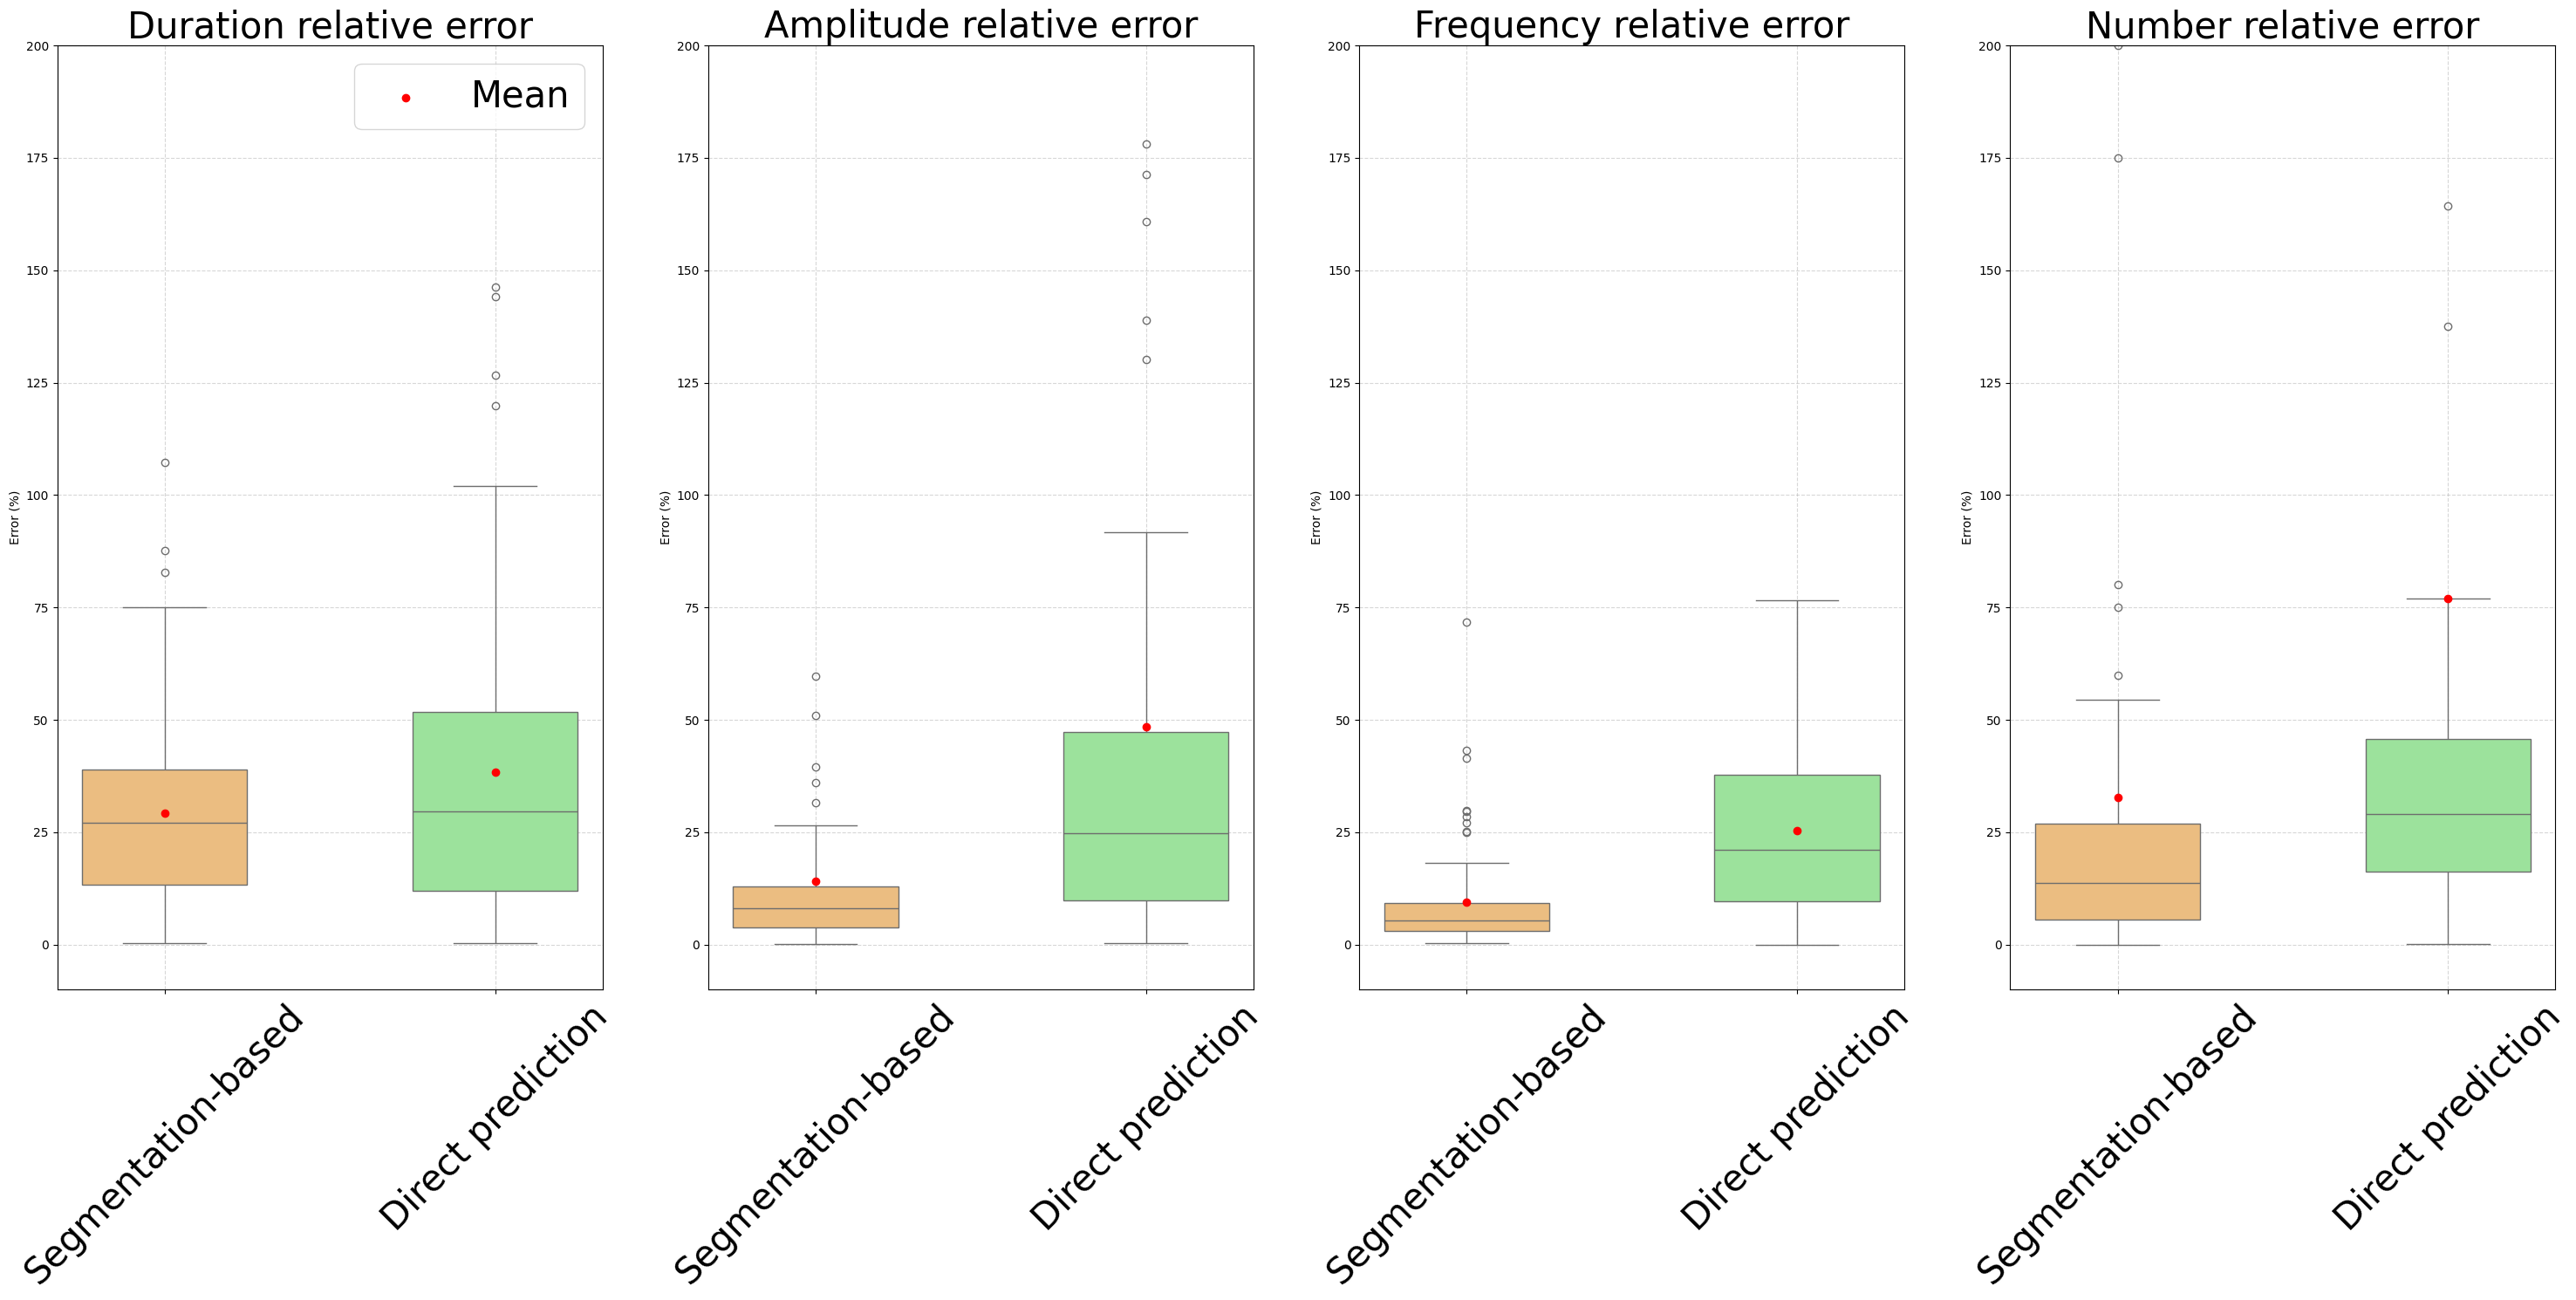

In [57]:
f, axes = plt.subplots(1, 4, figsize=(30, 15))
titles = ["Duration", "Amplitude", "Frequency", "Number"]
labels = ['Segmentation-based', 'Direct prediction']

for i in range(4):
    data = [
        unet_epi_dif.T[i] / unet_test_samples_char_true.T[i] * 100,
        unet_chars_difs[i] / unet_chars_answers[i] * 100
    ]
    
    sns.boxplot(data=data, ax=axes[i], width=0.5, 
                palette=['#fdbf6f', 'lightgreen'])
    
    # Добавляем средние значения
    for j, d in enumerate(data):
        axes[i].scatter(j, np.mean(d), color='red', zorder=5, label='Mean' if j==0 else "")
    
    axes[i].set_title(f"{titles[i]} relative error", fontsize=30)
    axes[i].set_xticklabels(labels, rotation=45, fontsize=30)
    axes[i].set_ylabel('Error (%)')
    axes[i].set_ylim(bottom=-10, top=200)
    axes[i].grid(True, linestyle='--', alpha=0.5)
    
    if i == 0:
        axes[i].legend(fontsize=30)

plt.tight_layout()

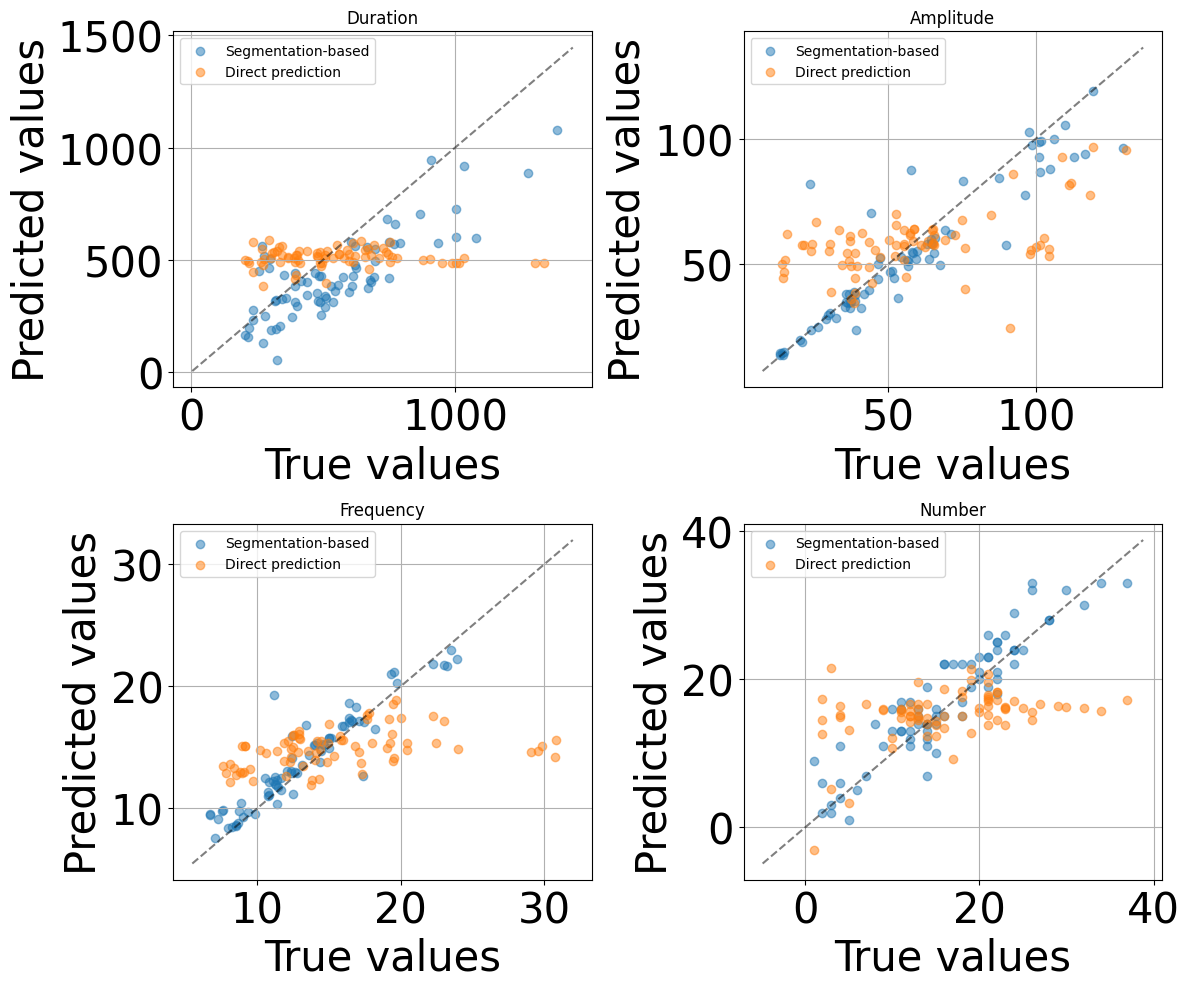

In [51]:
f, axes = plt.subplots(2, 2, figsize=(12, 10))
metrics = ['Duration', 'Amplitude', 'Frequency', 'Number']

for i, ax in enumerate(axes.flat):
    # Для подхода с сегментацией
    ax.scatter(unet_test_samples_char_true[:, i], unet_test_samples_char_pred[:, i], 
               alpha=0.5, label='Segmentation-based')
    # Для прямого предсказания
    ax.scatter(unet_chars_answers[i], unet_chars_preds[i], 
               alpha=0.5, label='Direct prediction')
    
    # Линия идеального предсказания
    lims = [
        min(ax.get_xlim()[0], ax.get_ylim()[0]),
        max(ax.get_xlim()[1], ax.get_ylim()[1])
    ]
    ax.plot(lims, lims, 'k--', alpha=0.5)
    
    ax.set_title(metrics[i])
    ax.set_xlabel('True values', fontsize=30)
    ax.set_ylabel('Predicted values', fontsize=30)
    ax.tick_params(labelsize=30)
    ax.legend()
    ax.grid(True)

plt.tight_layout()

Небольшое смещение настоящих значений из-за того, что для этих моделей требовалось брать немного смещенные участки записи, но каждый из способов сравнивался с настоящими метками на своем участке.

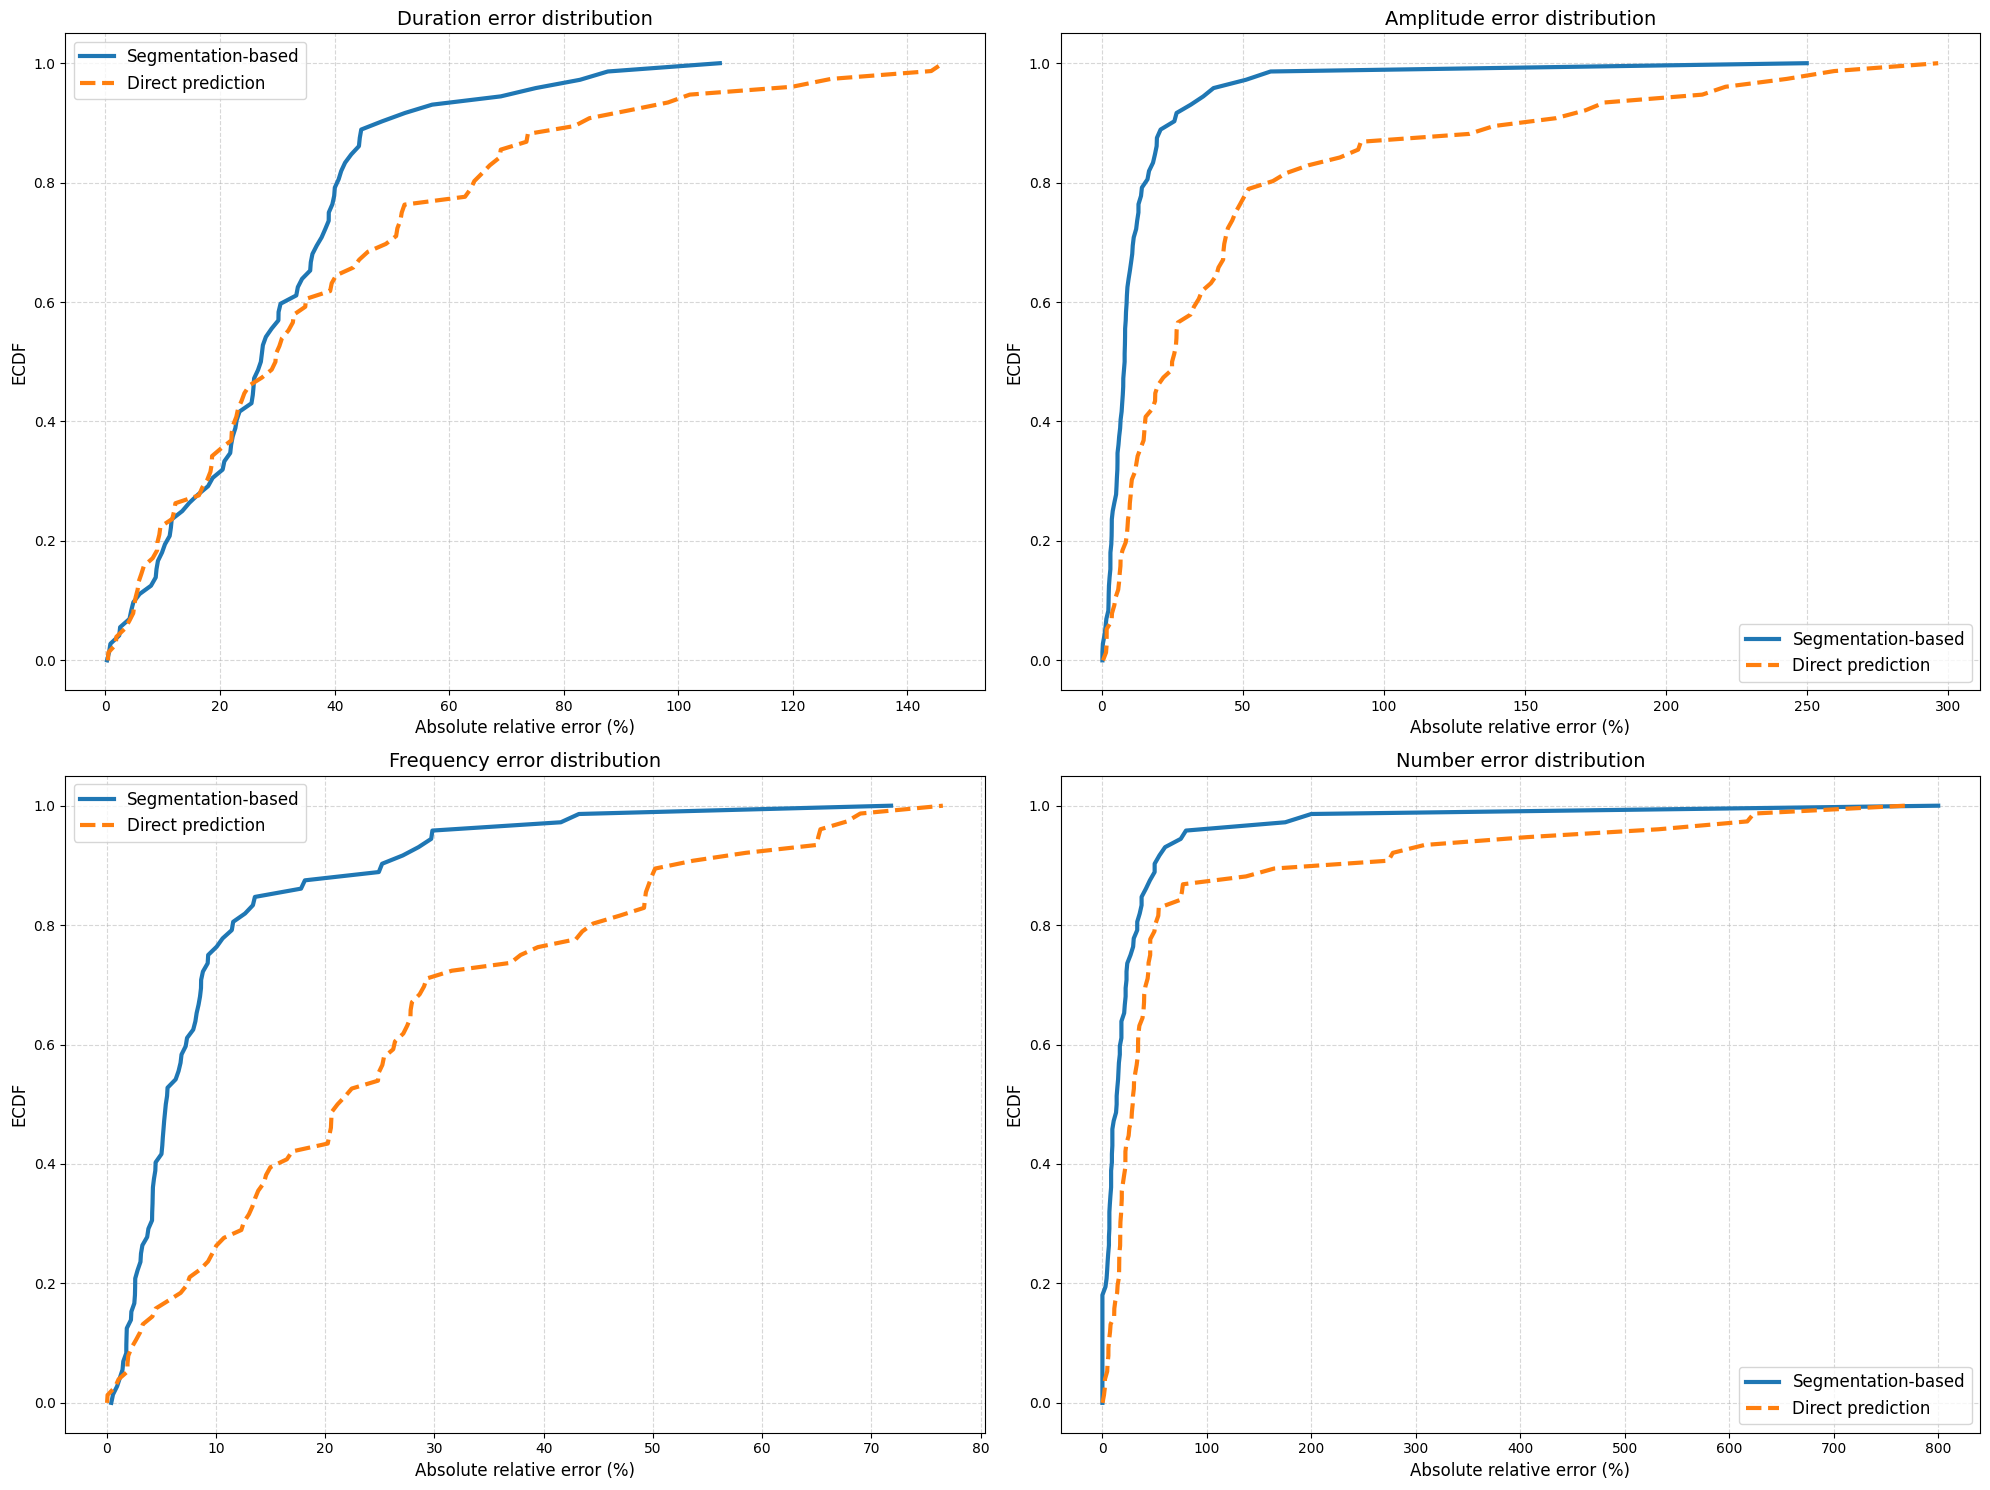

In [53]:
plt.figure(figsize=(20, 15))
metrics = ['Duration', 'Amplitude', 'Frequency', 'Number']

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    
    # Вычисляем относительные ошибки для обоих методов
    seg_errors = np.abs(unet_epi_dif.T[i-1] / unet_test_samples_char_true.T[i-1] * 100)
    direct_errors = np.abs(unet_chars_difs[i-1] / unet_chars_answers[i-1] * 100)
    
    # Очищаем от masked и nan значений
    seg_errors = np.ma.filled(seg_errors, np.nan)
    direct_errors = np.ma.filled(direct_errors, np.nan)
    seg_errors = seg_errors[~np.isnan(seg_errors)]
    direct_errors = direct_errors[~np.isnan(direct_errors)]
    
    # Сортируем для ECDF
    seg_sorted = np.sort(seg_errors)
    direct_sorted = np.sort(direct_errors)
    
    # Строим ECDF
    plt.plot(seg_sorted, np.linspace(0, 1, len(seg_sorted)), 
             linewidth=3, label='Segmentation-based')
    plt.plot(direct_sorted, np.linspace(0, 1, len(direct_sorted)), 
             '--', linewidth=3, label='Direct prediction')
    
    plt.xlabel('Absolute relative error (%)', fontsize=12)
    plt.ylabel('ECDF', fontsize=12)
    plt.title(f'{metric} error distribution', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    

plt.tight_layout()
plt.show()

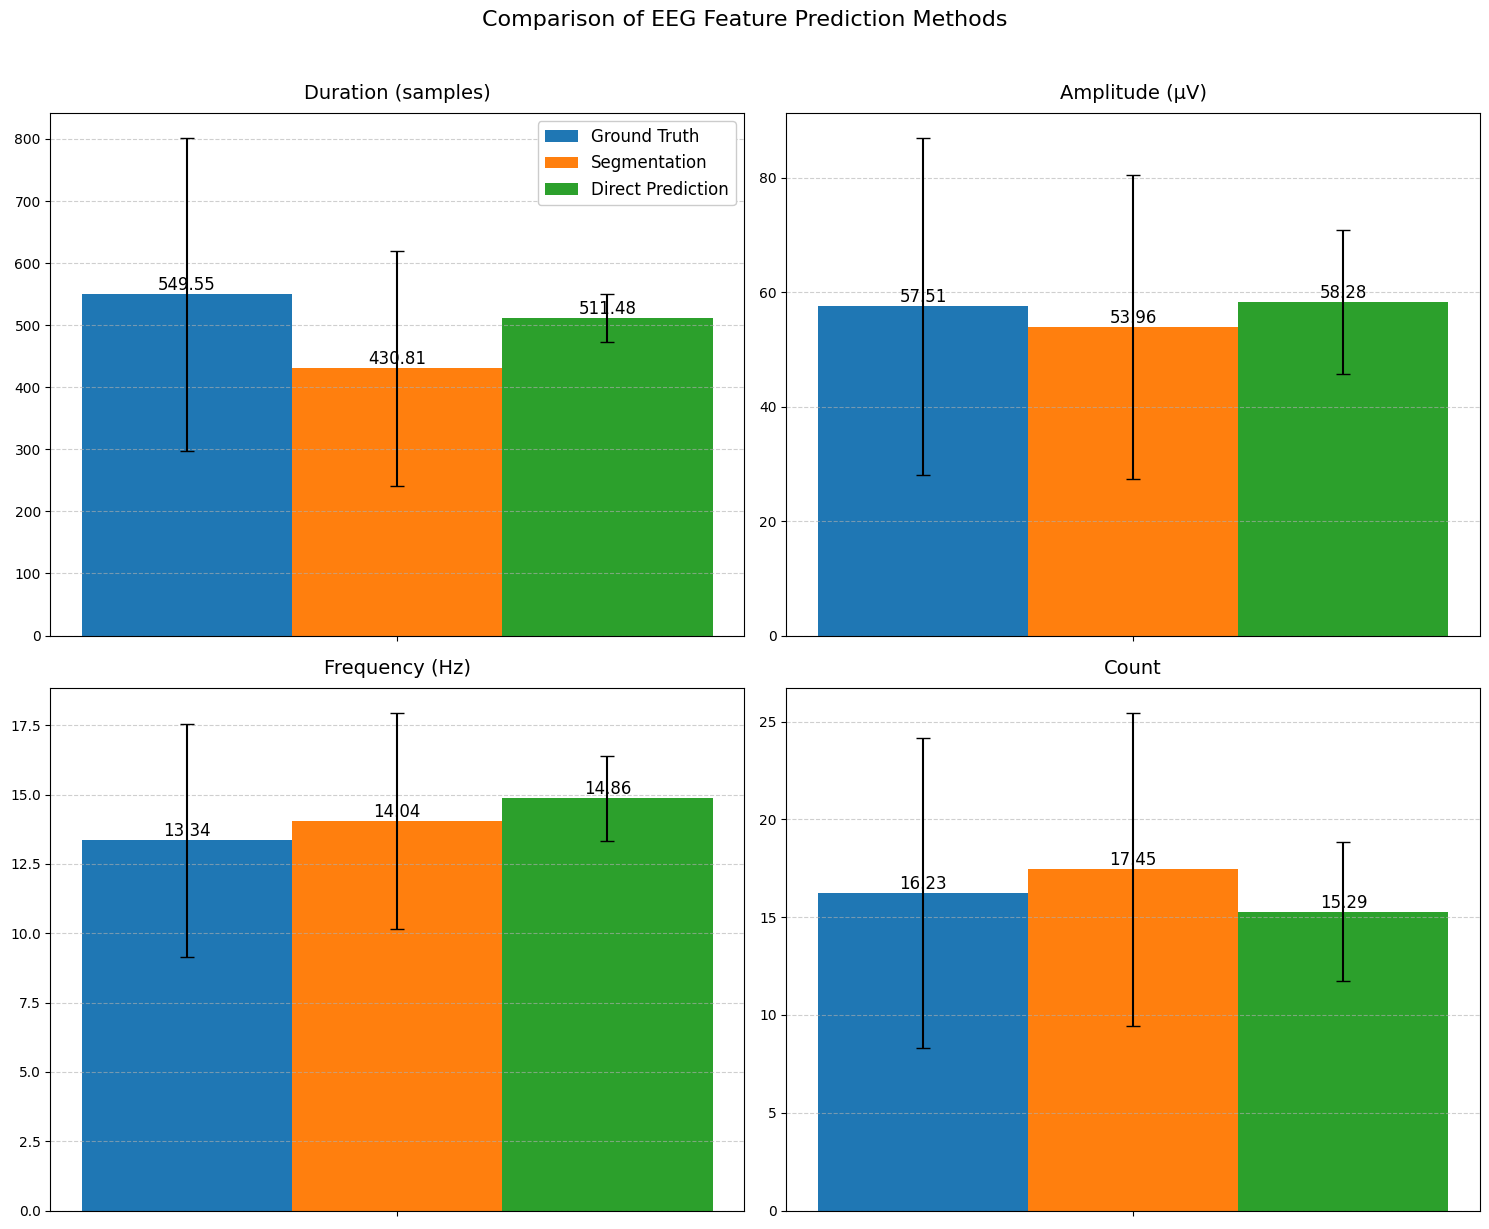

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Данные (примерные, замените на ваши)
metrics = ['Duration (samples)', 'Amplitude (μV)', 'Frequency (Hz)', 'Count']
true_means = [np.mean(unet_test_samples_char_true[:, i]) for i in range(4)]
seg_means = [np.mean(unet_test_samples_char_pred[:, i]) for i in range(4)]
direct_means = [np.mean(unet_chars_preds[i]) for i in range(4)]

# Ошибки (стандартное отклонение)
true_stds = [np.std(unet_test_samples_char_true[:, i]) for i in range(4)]
seg_stds = [np.std(unet_test_samples_char_pred[:, i]) for i in range(4)]
direct_stds = [np.std(unet_chars_preds[i]) for i in range(4)]

# Создаем 4 подграфика
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.4)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # blue, orange, green

for i, ax in enumerate(axes.flat):
    # Позиции столбцов
    x = np.arange(1)
    width = 0.25
    
    # Столбцы
    rects1 = ax.bar(x - width, true_means[i], width, 
                    label='Ground Truth', color=colors[0], 
                    yerr=true_stds[i], capsize=5)
    rects2 = ax.bar(x, seg_means[i], width, 
                    label='Segmentation', color=colors[1],  
                    yerr=seg_stds[i], capsize=5)
    rects3 = ax.bar(x + width, direct_means[i], width, 
                    label='Direct Prediction', color=colors[2],  
                    yerr=direct_stds[i], capsize=5)
    
    # Настройки графика
    ax.set_title(metrics[i], fontsize=14, pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels([''])
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    
    # Добавляем значения над столбцами
    for rect in [rects1, rects2, rects3]:
        height = rect[0].get_height()
        ax.text(rect[0].get_x() + rect[0].get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=12)
    
    # Добавляем легенду только на первом графике
    if i == 0:
        ax.legend(fontsize=12, framealpha=1)

# Общий заголовок
plt.suptitle('Comparison of EEG Feature Prediction Methods', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

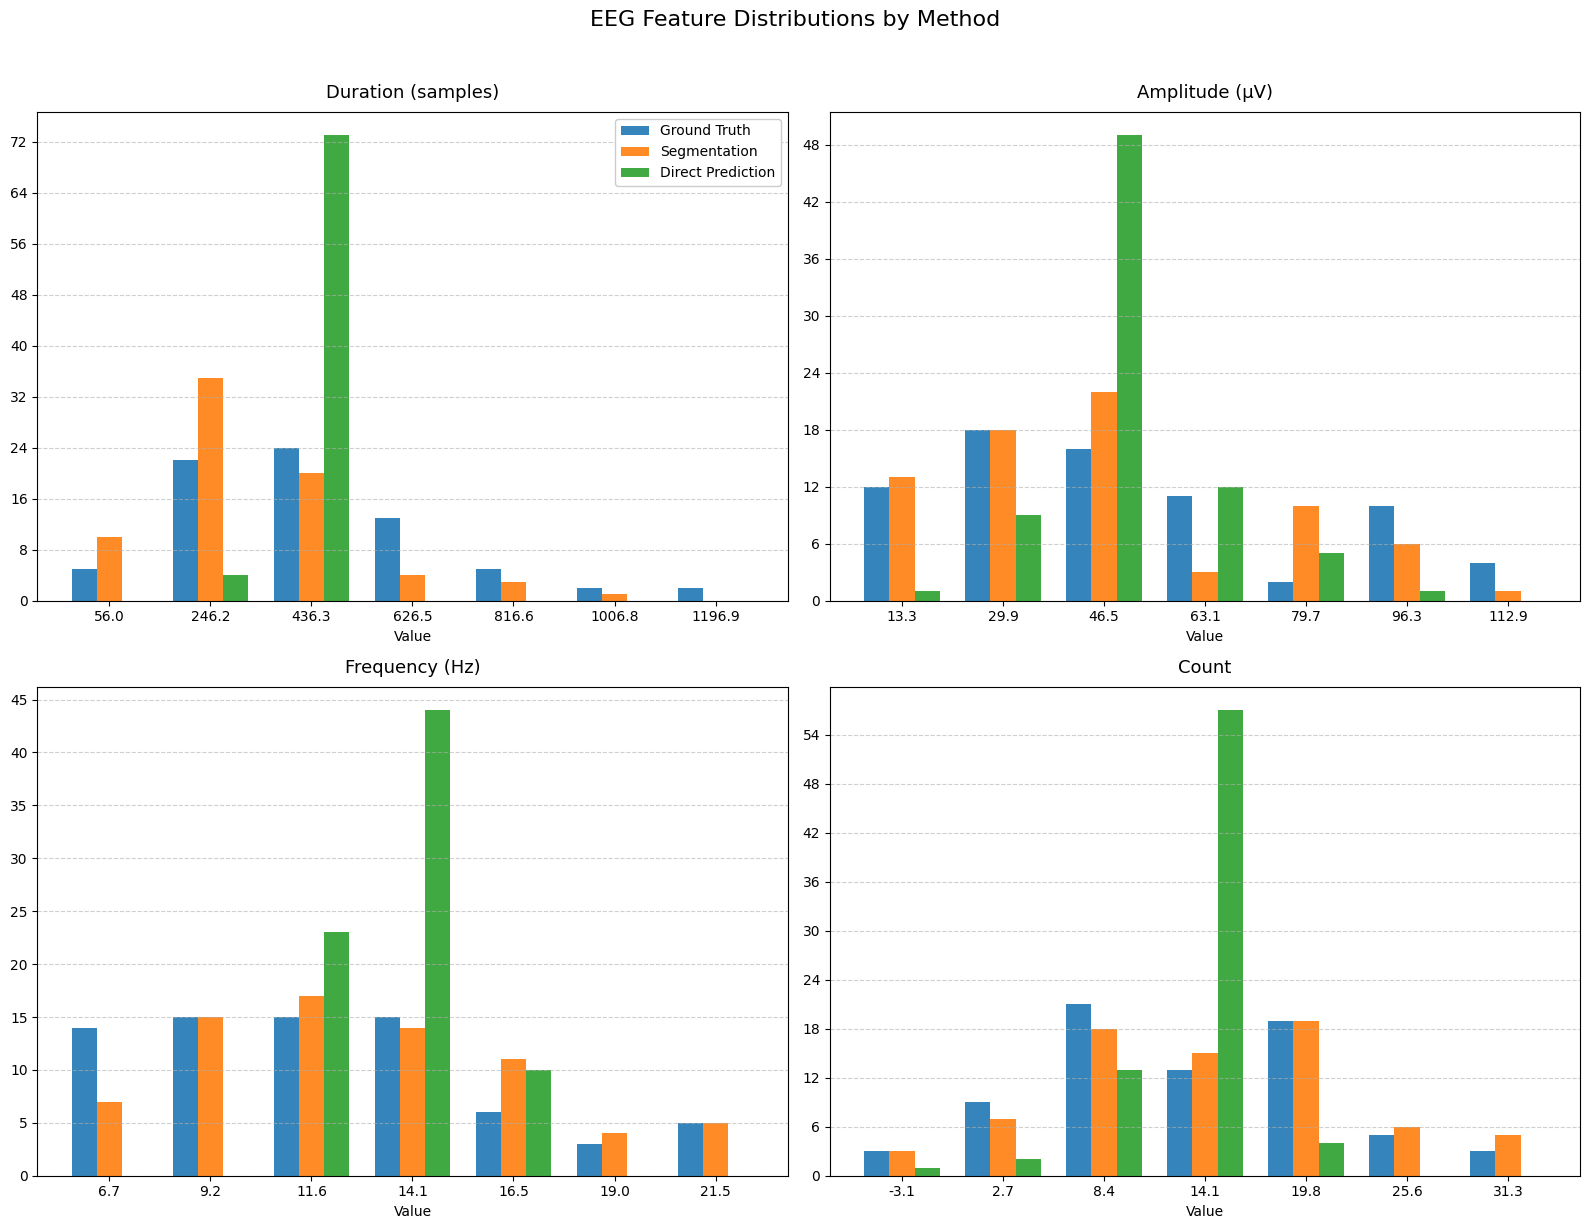

In [75]:
from matplotlib.ticker import MaxNLocator

# Настройки
metrics = ['Duration (samples)', 'Amplitude (μV)', 'Frequency (Hz)', 'Count']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # blue, orange, green
bar_width = 0.25

# Создаем 4 подграфика
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

for i, ax in enumerate(axes.flat):
    # Подготовка данных
    true_vals = np.ma.filled(unet_test_samples_char_true[:, i], np.nan)
    seg_vals = np.ma.filled(unet_test_samples_char_pred[:, i], np.nan)
    dir_vals = np.ma.filled(unet_chars_preds[i], np.nan)
    
    # Общие bins для всех методов
    combined = np.concatenate([true_vals[~np.isnan(true_vals)], 
                              seg_vals[~np.isnan(seg_vals)],
                              dir_vals[~np.isnan(dir_vals)]])
    bins = np.linspace(np.min(combined), np.max(combined), 8)  # Уменьшили число бинов для читаемости
    
    # Гистограммы
    hist_true, _ = np.histogram(true_vals, bins=bins)
    hist_seg, _ = np.histogram(seg_vals, bins=bins)
    hist_dir, _ = np.histogram(dir_vals, bins=bins)
    
    # Позиции столбцов (центрированные)
    x = np.arange(len(bins)-1)
    
    # Рисуем столбцы
    ax.bar(x - bar_width, hist_true, width=bar_width, 
           color=colors[0], alpha=0.9, label='Ground Truth')
    ax.bar(x, hist_seg, width=bar_width, 
           color=colors[1], alpha=0.9, label='Segmentation')
    ax.bar(x + bar_width, hist_dir, width=bar_width, 
           color=colors[2], alpha=0.9, label='Direct Prediction')
    
    # Оформление осей
    ax.set_title(metrics[i], fontsize=13, pad=10)
    ax.set_xticks(x)  # Просто числа без диапазонов
    ax.set_xticklabels([f"{bins[j]:.1f}" for j in range(len(bins)-1)], rotation=0)  # Центральные значения бинов
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.set_xlabel('Value', fontsize=10)
    
    if i == 0:
        ax.legend(fontsize=10, framealpha=1)

plt.suptitle('EEG Feature Distributions by Method', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

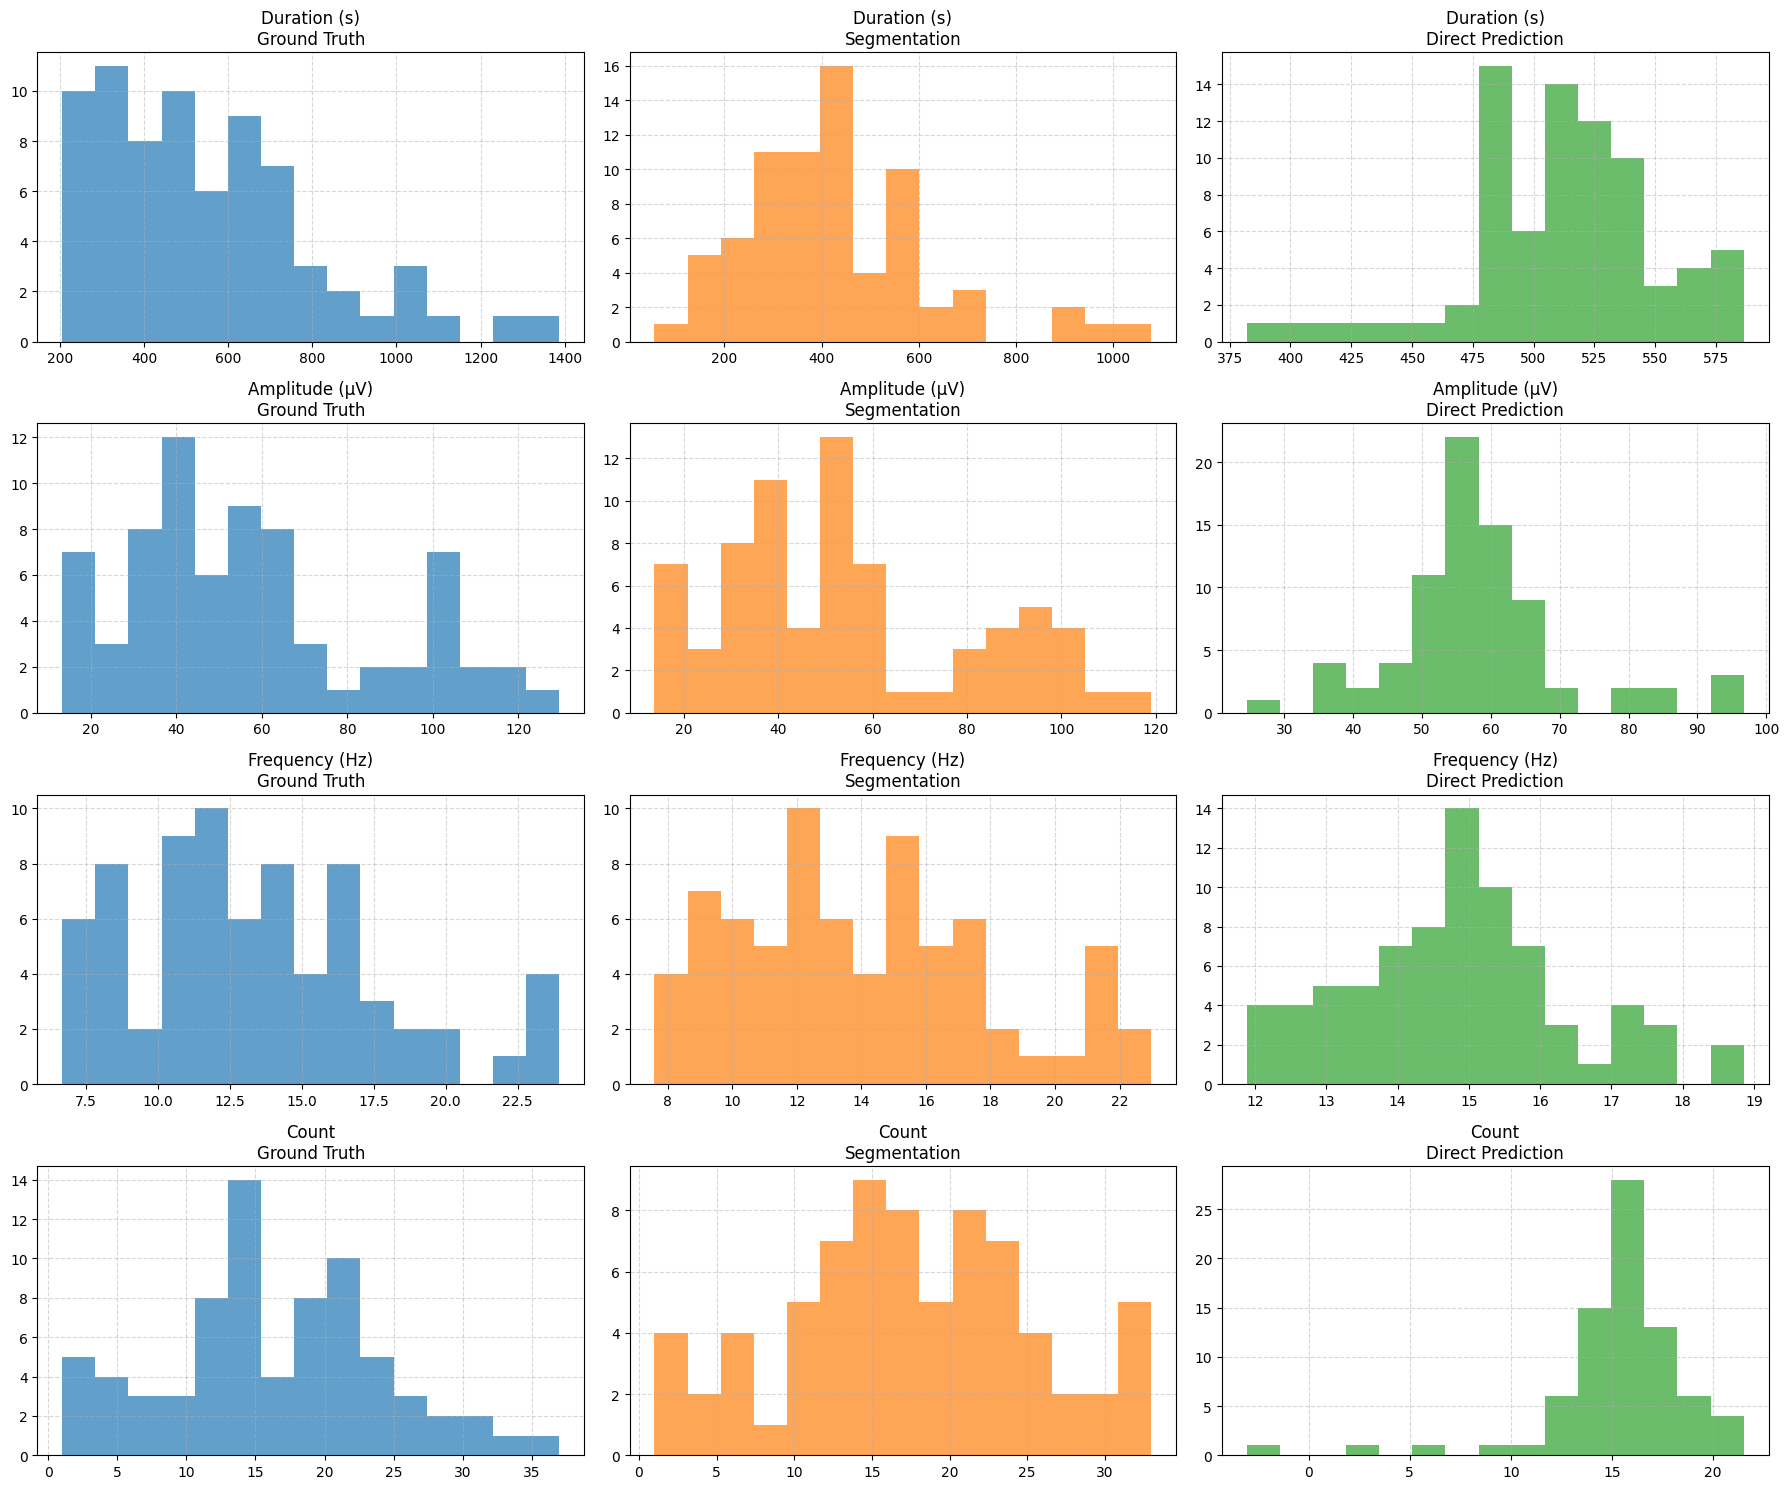

In [69]:
fig, axes = plt.subplots(4, 3, figsize=(18, 15))

for i in range(4):
    # Ground Truth
    axes[i, 0].hist(unet_test_samples_char_true[:, i], bins=15,
                   color='#1f77b4', alpha=0.7)
    axes[i, 0].set_title(f'{metrics[i]}\nGround Truth')
    
    # Segmentation
    axes[i, 1].hist(unet_test_samples_char_pred[:, i], bins=15,
                   color='#ff7f0e', alpha=0.7)
    axes[i, 1].set_title(f'{metrics[i]}\nSegmentation')
    
    # Direct Prediction
    axes[i, 2].hist(unet_chars_preds[i], bins=15,
                   color='#2ca02c', alpha=0.7)
    axes[i, 2].set_title(f'{metrics[i]}\nDirect Prediction')

    for j in range(3):
        axes[i, j].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()

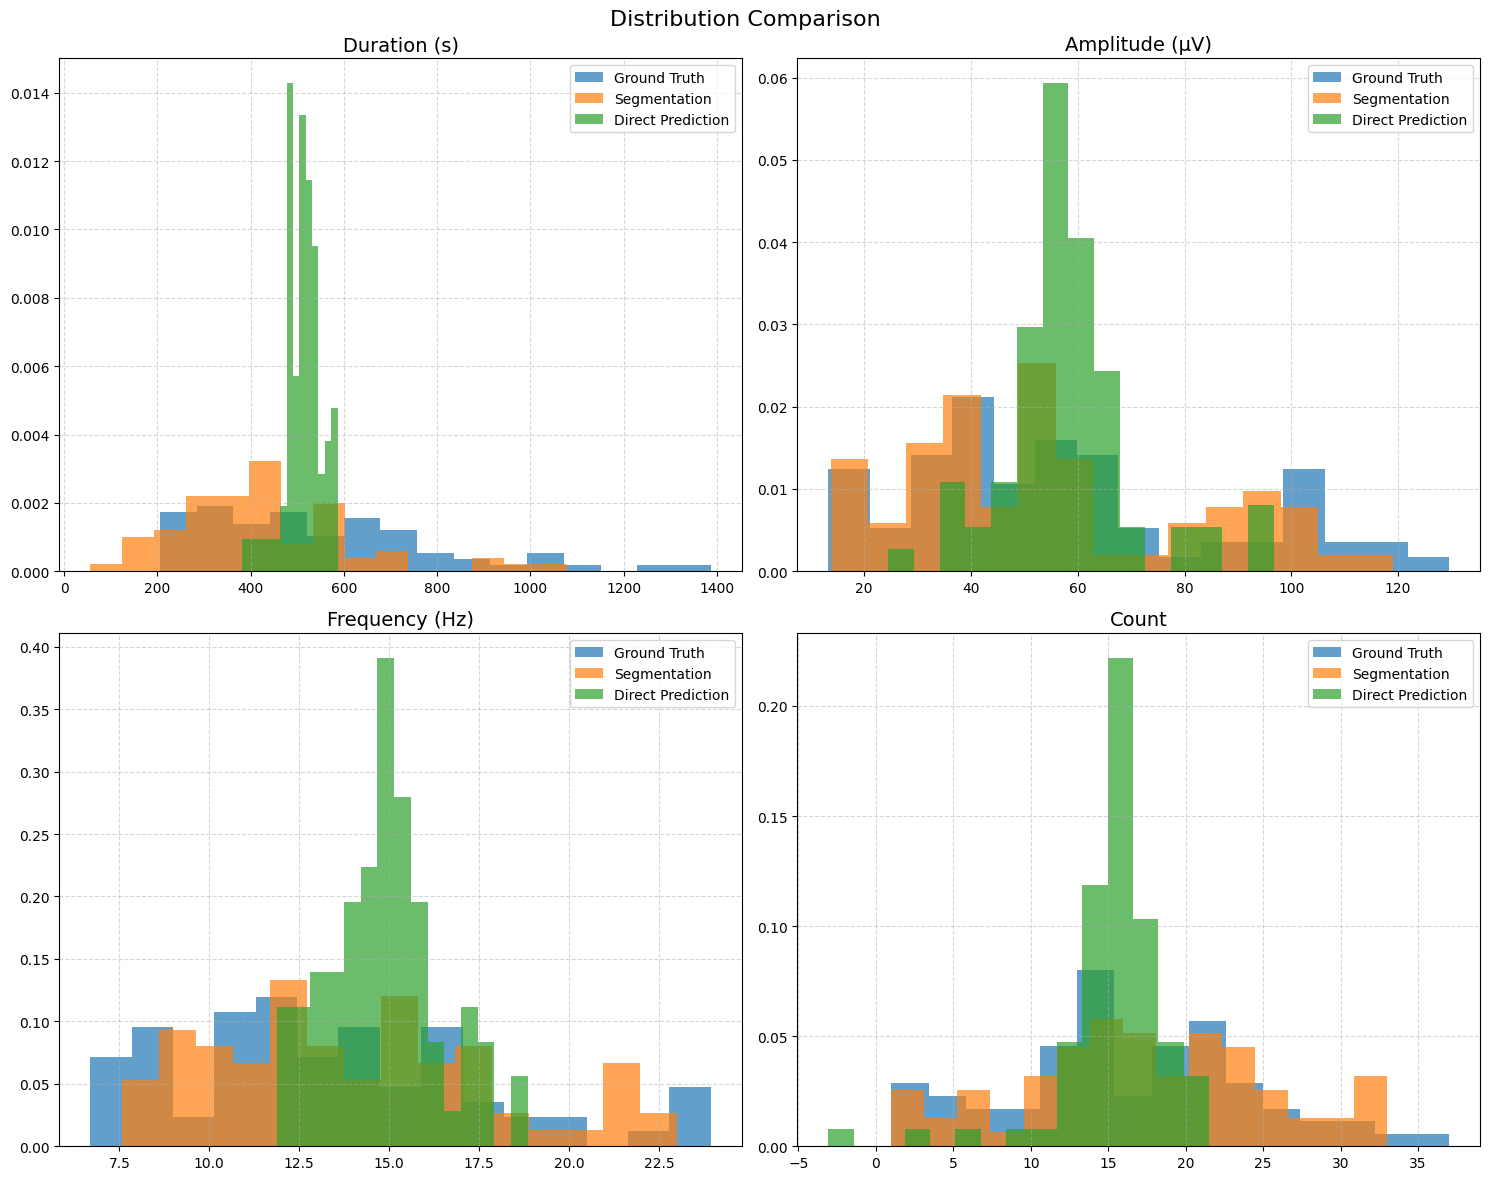

In [67]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

for i, ax in enumerate(axes.flat):
    true_vals = unet_test_samples_char_true[:, i]
    seg_vals = unet_test_samples_char_pred[:, i]
    dir_vals = unet_chars_preds[i]
    
    # Убедимся, что данные не содержат NaN/masked значений
    true_vals = np.ma.filled(true_vals, np.nan)
    seg_vals = np.ma.filled(seg_vals, np.nan)
    dir_vals = np.ma.filled(dir_vals, np.nan)
    
    # Гистограммы с раздельными цветами
    ax.hist([true_vals[~np.isnan(true_vals)]], 
            bins=15, alpha=0.7, color='#1f77b4', 
            label='Ground Truth', density=True)
    ax.hist([seg_vals[~np.isnan(seg_vals)]], 
            bins=15, alpha=0.7, color='#ff7f0e', 
            label='Segmentation', density=True)
    ax.hist([dir_vals[~np.isnan(dir_vals)]], 
            bins=15, alpha=0.7, color='#2ca02c', 
            label='Direct Prediction', density=True)
    
    ax.set_title(metrics[i], fontsize=14)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

plt.suptitle('Distribution Comparison', fontsize=16)
plt.tight_layout()